In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Utilities

In [48]:
# Utility functions
import pandas as pd
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error


from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, y_pred, labels=None):
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=labels)

    # Create a DataFrame from the confusion matrix for better labeling in the heatmap
    if labels is None:
        labels = sorted(set(y_test) | set(y_pred))
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()


def split_data(dataframe):
  # Split data into features and target
  X = dataframe.drop(columns=['label', 'label_1'])
  y = dataframe['label']

  # Encode labels if they are strings
  if y.dtype == 'object':
      label_encoder = LabelEncoder()
      y = label_encoder.fit_transform(y)

  # Split data into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  return X_train, X_test, y_train, y_test



def train_classifier(X_train, X_test, y_train, classifier):
  # Train the classifier
  if classifier == 'SVM':
    classifier = SVC(kernel='rbf', decision_function_shape='ovr')
  else:
    classifier = KNeighborsClassifier()
  classifier.fit(X_train, y_train)

  # Predict on the test set
  return classifier.predict(X_test)


def train_on_all_features(dataframe, classifier):
  # Split data into train and test sets
  X_train, X_test, y_train, y_test = split_data(dataframe)

  y_pred = train_classifier(X_train, X_test, y_train, classifier)

  # Evaluate the classifier
  report = classification_report(y_test, y_pred)
  print("Classification Report:\n", report)
  return y_pred, y_test



def train_on_single_features(dataframe, selected_features, classifier):
  # Split data into train and test sets
  X_train, X_test, y_train, y_test = split_data(dataframe)

  for subset_name, subset_regex in selected_features.items():
      # Filter columns based on regular expression patterns
      subset_X_train = X_train.filter(regex=subset_regex)
      subset_X_test = X_test.filter(regex=subset_regex)

      y_pred = train_classifier(subset_X_train, subset_X_test, y_train, classifier)

      # Calculate and print the accuracy for each classifier
      accuracy = accuracy_score(y_test, y_pred)
      print(f"Accuracy for {subset_name}: {accuracy}")
      plot_confusion_matrix(y_test, y_pred)


# Function to filter rows based on the condition
def filter_dataframe(df):
    # Extract the numeric part from 'label_1' and convert to integer
    df['numeric_part'] = df['label_1'].apply(lambda x: int(x.split('_')[-1]))

    # Filter the dataframe where the numeric part is less than or equal to 400
    filtered_df = df[df['numeric_part'] <= 700].drop(columns=['numeric_part'])

    return filtered_df


def string_to_list(string):
    try:
        print(string)
        # Remove '[' and ']' characters, then split the string by whitespace
        parts = string.strip('[]').replace(',', '').replace('j', '').replace('e', '').replace('+', ' ').replace('-', ' ').split()

        # Convert each part to a double and create a list
        result = [float(part) for part in parts]
        return result
    except ValueError as e:
        print(f"Error: {e}")
        return None

# Function to unpack list columns into multiple columns
def unpack_lists(df):
    for col in df.columns:
        if isinstance(df[col][0], list):
            # print(col)
            max_len = max(len(sublist) for sublist in df[col])
            for i in range(max_len):
                df[f'{col}{i}'] = df[col].apply(lambda x: x[i] if len(x) > i else None)
            df.drop(columns=[col], inplace=True)
    return df


def load_dataframe_from_csv(file_path = None, df = None):
    if file_path != None:
      df = pd.read_csv(file_path)

    if df is not None:
      df = df.dropna()

      transformed_df = df.copy()
      for column in df.columns:
          if column != 'label' and column != 'label_1':
              transformed_df[column] = df[column].apply(string_to_list)

      transformed_df = transformed_df.dropna()

      # Unpack the lists into separate columns
      unpacked_df = unpack_lists(transformed_df)

      unpacked_df = unpacked_df.dropna(axis=1, how='any')

      return unpacked_df
    else:
      raise Exception("No dataframe or filepath specified")

# Perform feature selection

In [ ]:
column_subsets = {
      'A1': 'mfcc\d{1,3}|ssd\d{1,3}',
      'A2': 'mfcc\d{1,3}|ssd\d{1,3}|rh\d{1,3}',
      'A3': 'mfcc\d{1,3}|ssd\d{1,3}|mvd\d{1,3}',
      'S1': 'S-LBP\d{1,3}|S-LBPHF\d{1,3}|S-LPQ\d{1,3}',
      'S2': 'S-LBP\d{1,3}|S-LBPHF\d{1,3}|S-RICLBP\d{1,3}',
      'S3': 'S-LBP\d{1,3}|S-LPQ\d{1,3}',
      'S4': 'S-LBP\d{1,3}|S-RICLBP\d{1,3}',
      # 'S5': 'tssd\d{1,3}',
      'S6': 'S-LBP\d{1,3}|S-RICLBP\d{1,3}|S-LPQ\d{1,3}',
      # 'S7': 'tssd\d{1,3}',
      'F1': 'mfcc\d{1,3}|ssd\d{1,3}|rh\d{1,3}|S-LPQ\d{1,3}',
      'F2': 'mfcc\d{1,3}|ssd\d{1,3}|rh\d{1,3}|S-LBP\d{1,3}|S-LPQ\d{1,3}',
      # 'F3': 'mfcc\d{1,3}|ssd\d{1,3}|rh\d{1,3}|',
      'F4': 'mfcc\d{1,3}|ssd\d{1,3}|rh\d{1,3}|S-LBP\d{1,3}|S-LPQ\d{1,3}|M-LBP\d{1,3}',
      'F5': 'mfcc\d{1,3}|ssd\d{1,3}|rh\d{1,3}|S-LBP\d{1,3}|S-LPQ\d{1,3}|M-LBPHF\d{1,3}',
      'F6': 'mfcc\d{1,3}|ssd\d{1,3}|rh\d{1,3}|S-LBP\d{1,3}|S-LPQ\d{1,3}|M-RICLBP\d{1,3}',
      # 'F7': 'tssd\d{1,3}',
      'F8': 'mfcc\d{1,3}|ssd\d{1,3}|rh\d{1,3}|S-LBP\d{1,3}|S-LPQ\d{1,3}|M-LPQ\d{1,3}',
      'G1': 'ssd\d{1,3}|tssd\d{1,3}|S-LBP\d{1,3}|S-RICLBP\d{1,3}|S-LPQ\d{1,3}'
  }

## Gtzan

In [ ]:
import pandas as pd

acoustic_feature_file = '/content/drive/MyDrive/Università/NAML_project/datasets_processed/gtzan_acoustic_features.csv'
spectrum_feature_file = '/content/drive/MyDrive/Università/NAML_project/datasets_processed/gtzan_spectrum_texture_features.csv'
aim_feature_file = '/content/drive/MyDrive/Università/NAML_project/datasets_processed/gtzan_aim_texture_features.csv'

af = load_dataframe_from_csv(file_path = acoustic_feature_file)
sf = load_dataframe_from_csv(file_path = spectrum_feature_file)
aim = load_dataframe_from_csv(file_path = aim_feature_file)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
sf.columns = ['S-' + col if col not in ['label', 'label_1'] else col for col in sf.columns]
aim.columns = ['M-' + col if col not in ['label', 'label_1'] else col for col in aim.columns]

full_df = pd.merge(af, sf, on='label_1', how='inner')
full_df = full_df.drop(columns=['label_y'])
full_df = full_df.rename(columns={'label_x': 'label'})

full_df = pd.merge(full_df, aim, on='label_1', how='inner')
full_df = full_df.drop(columns=['label_y'])
full_df = full_df.rename(columns={'label_x': 'label'})

In [ ]:
full_df.head()

,label_1,label,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,...,M-LPQ500,M-LPQ501,M-LPQ502,M-LPQ503,M-LPQ504,M-LPQ505,M-LPQ506,M-LPQ507,M-LPQ508,M-LPQ509
0,pop_1,pop,222.629349,109.600151,8.275423,2.573467,9.491745,11.674646,15.712113,4.138751,...,0.0,0.0,5.510088,4.0,1.162791,3.0,5.029171,2.0,4.618751,4.0
1,pop_2,pop,14.677280,77.672806,0.129021,22.647038,17.026323,3.309944,9.159575,2.875973,...,0.0,0.0,4.456689,4.0,1.073657,3.0,5.887691,2.0,4.213597,4.0
2,pop_3,pop,93.867683,43.445122,7.478451,0.088349,6.007252,4.361706,0.094539,3.452164,...,0.0,0.0,5.185965,4.0,8.305648,4.0,4.371607,2.0,8.103071,4.0
3,pop_4,pop,152.060471,35.500843,30.377958,14.888762,21.653246,0.808262,3.577241,0.581427,...,0.0,0.0,4.659266,4.0,9.196986,4.0,5.617049,2.0,4.537720,4.0
4,pop_5,pop,217.278137,126.350746,20.070490,19.959452,1.837735,10.512690,0.844215,8.748989,...,0.0,0.0,4.254112,4.0,8.872863,4.0,5.751560,2.0,4.699781,4.0


SVM results:
Accuracy for A1: 0.3879598662207358


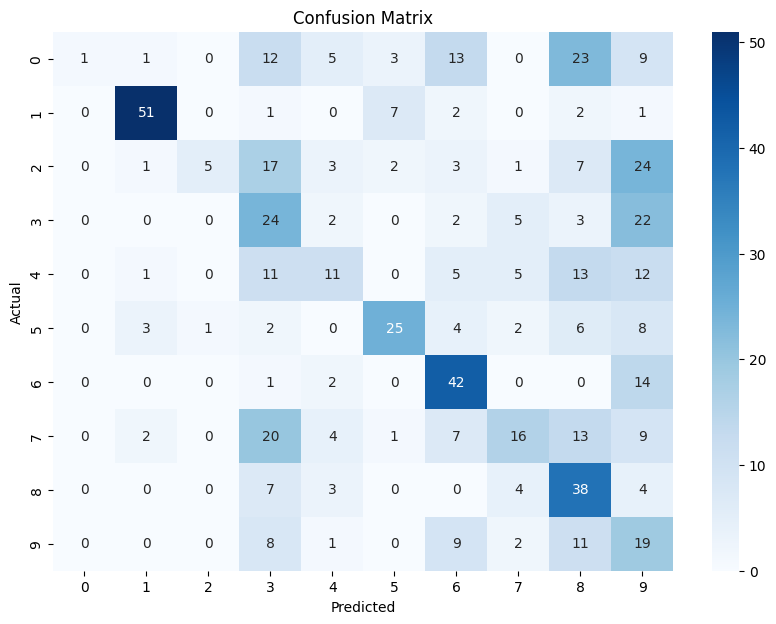

Accuracy for A2: 0.3896321070234114


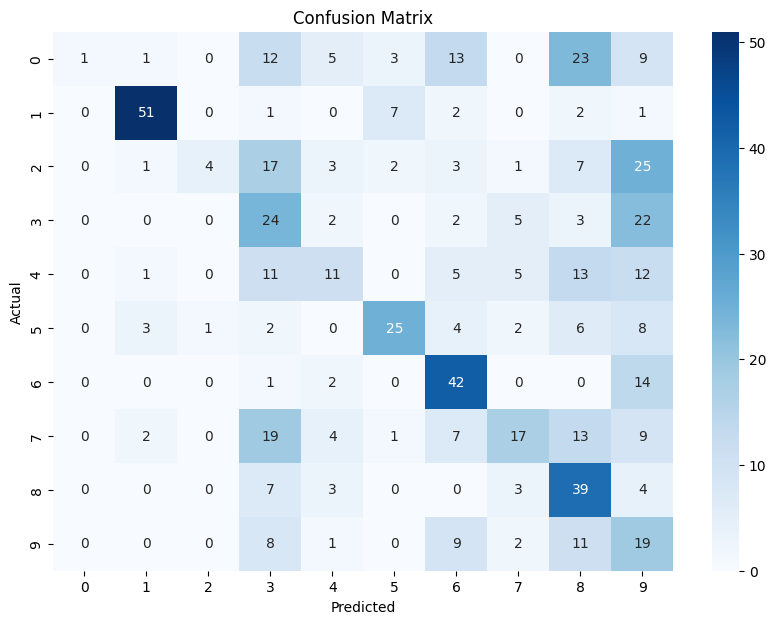

Accuracy for A3: 0.3879598662207358


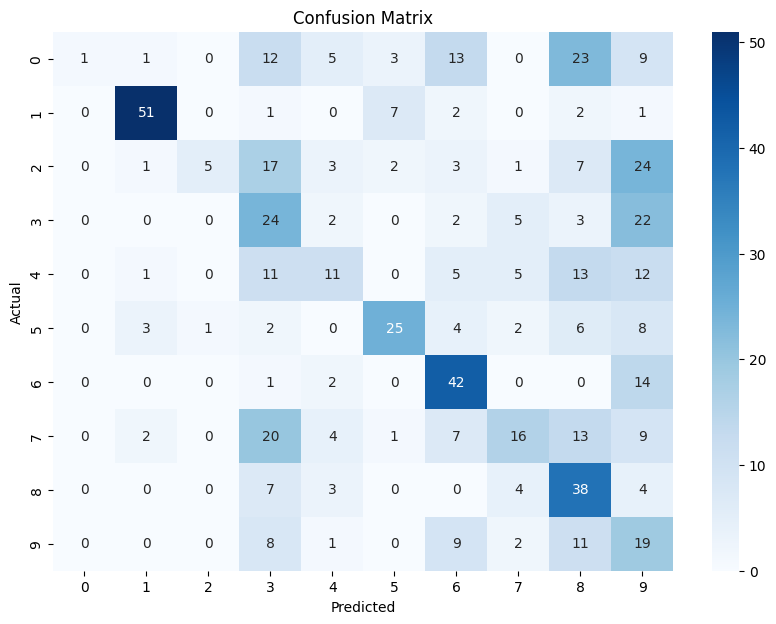

Accuracy for S1: 0.20735785953177258


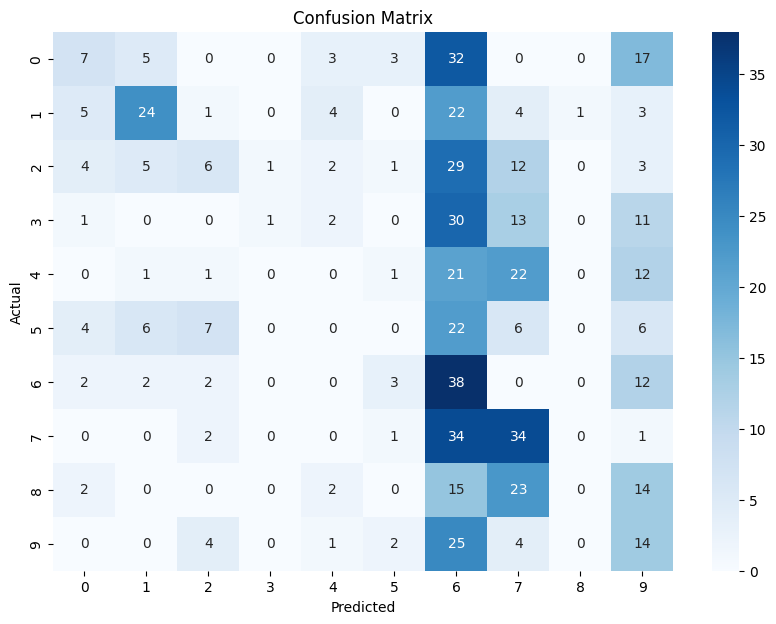

Accuracy for S2: 0.3762541806020067


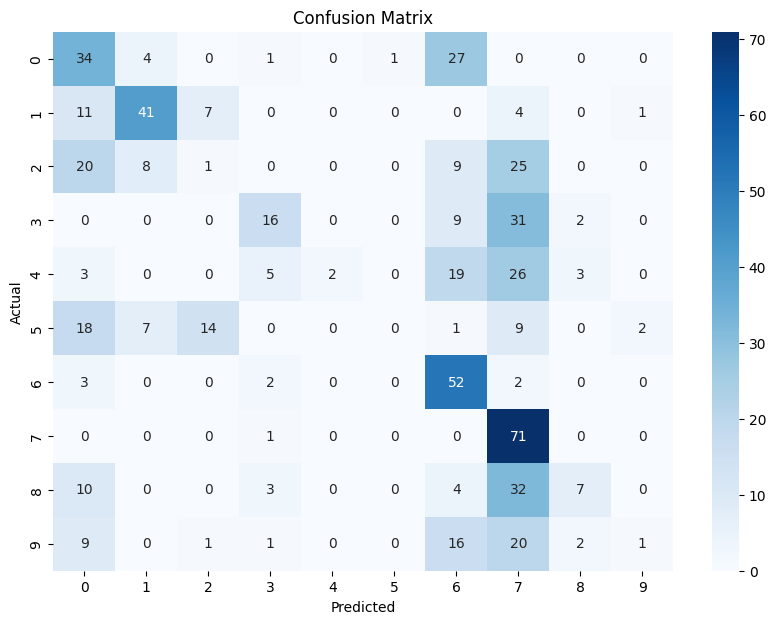

Accuracy for S3: 0.10033444816053512


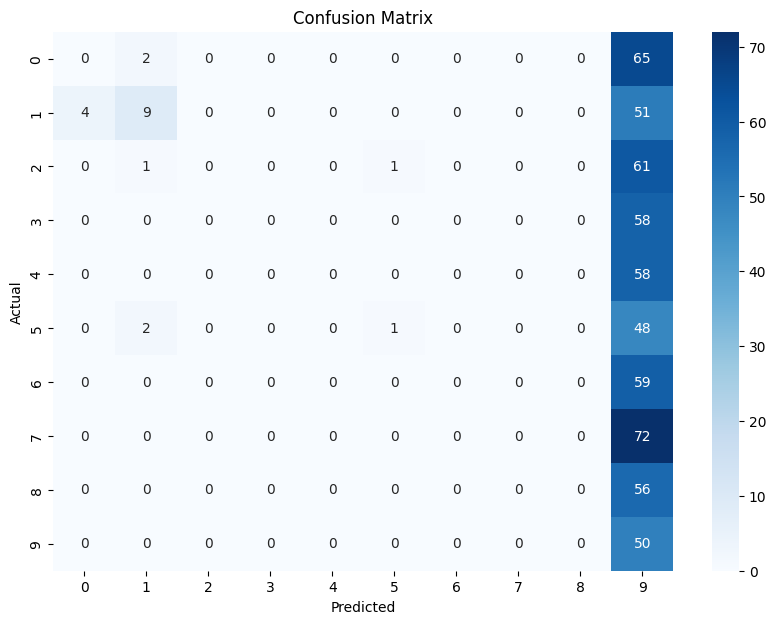

Accuracy for S4: 0.3779264214046823


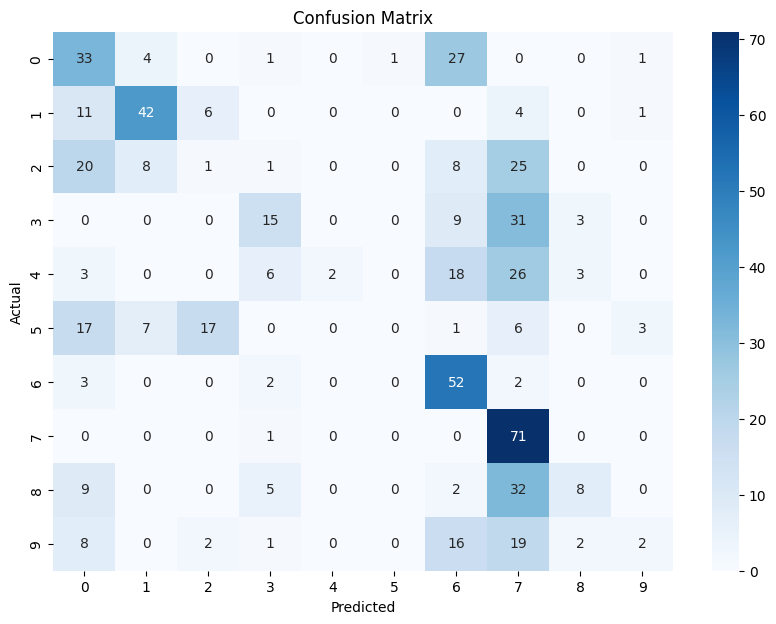

Accuracy for S6: 0.3712374581939799


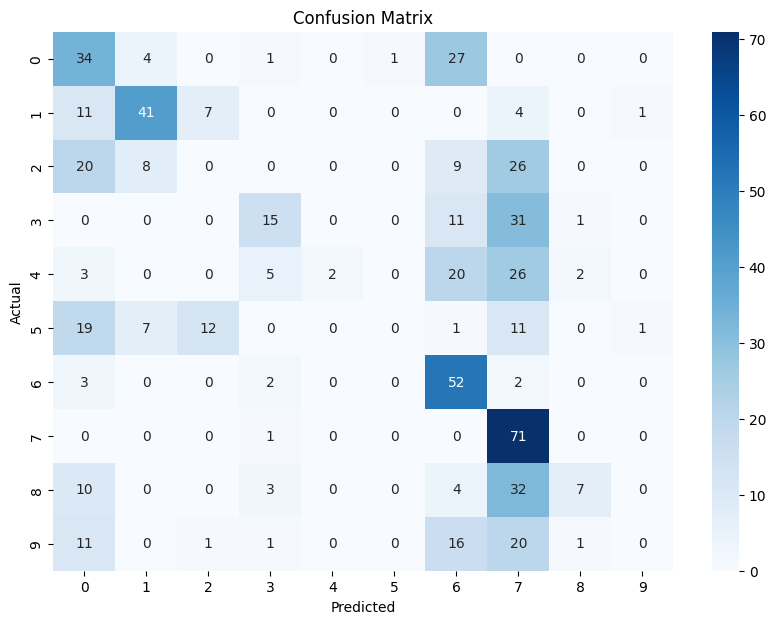

Accuracy for F1: 0.3862876254180602


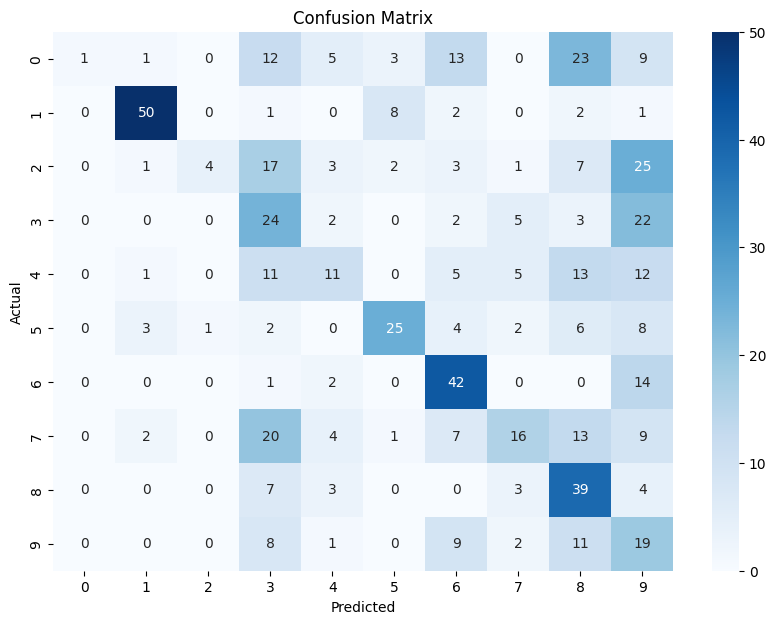

Accuracy for F2: 0.3862876254180602


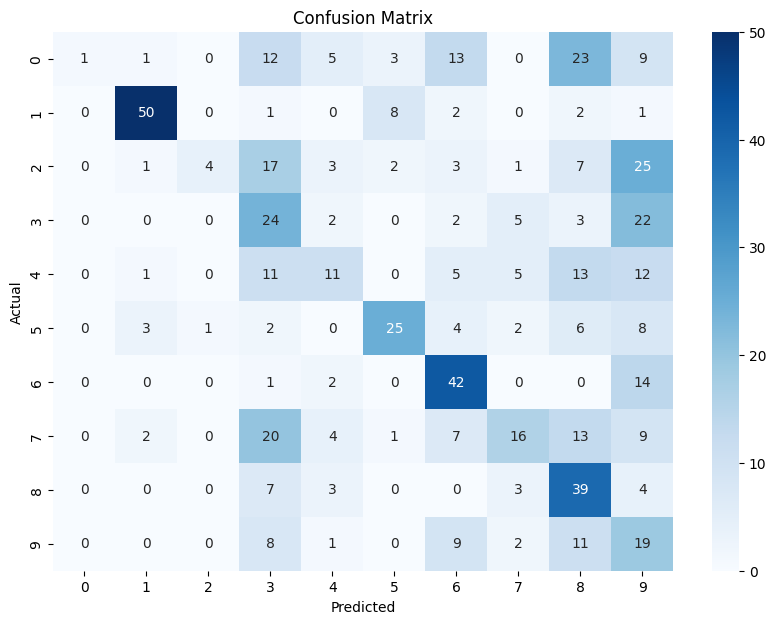

Accuracy for F4: 0.3862876254180602


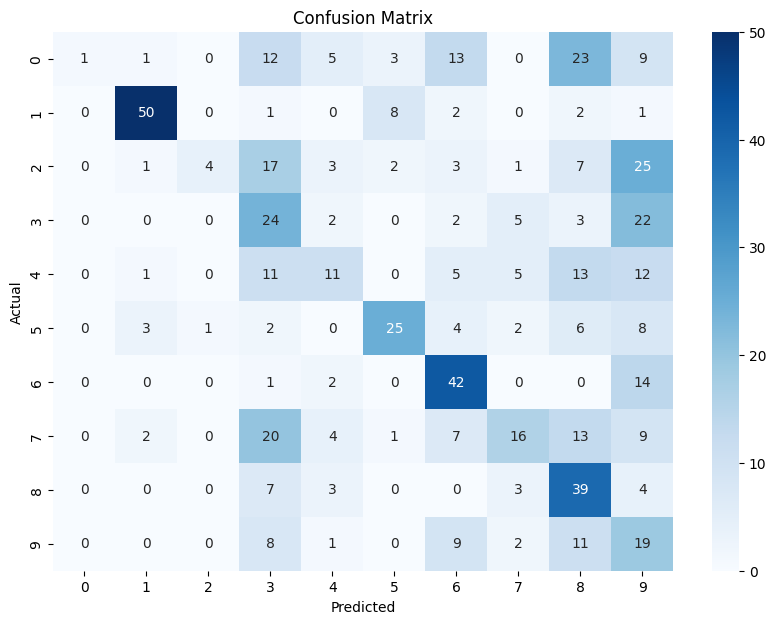

Accuracy for F5: 0.3879598662207358


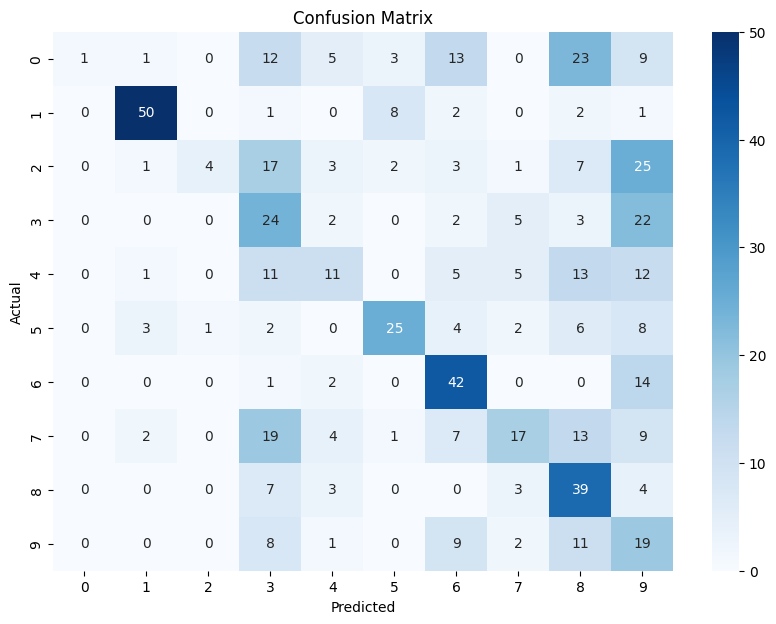

Accuracy for F6: 0.08695652173913043


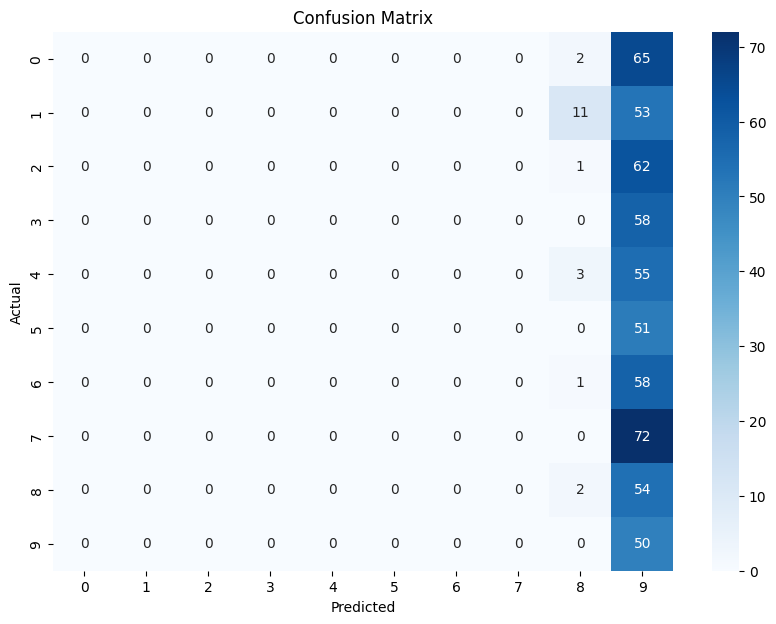

Accuracy for F8: 0.3862876254180602


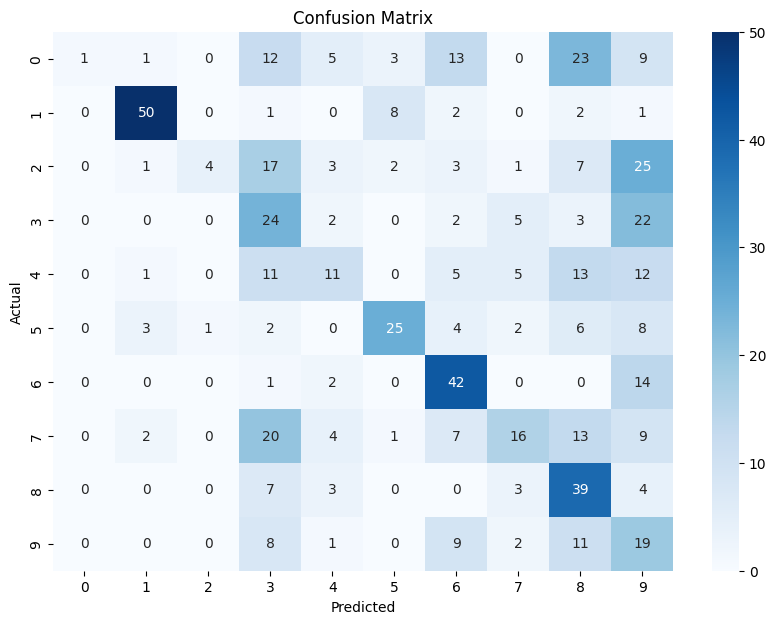

Accuracy for G1: 0.36622073578595316


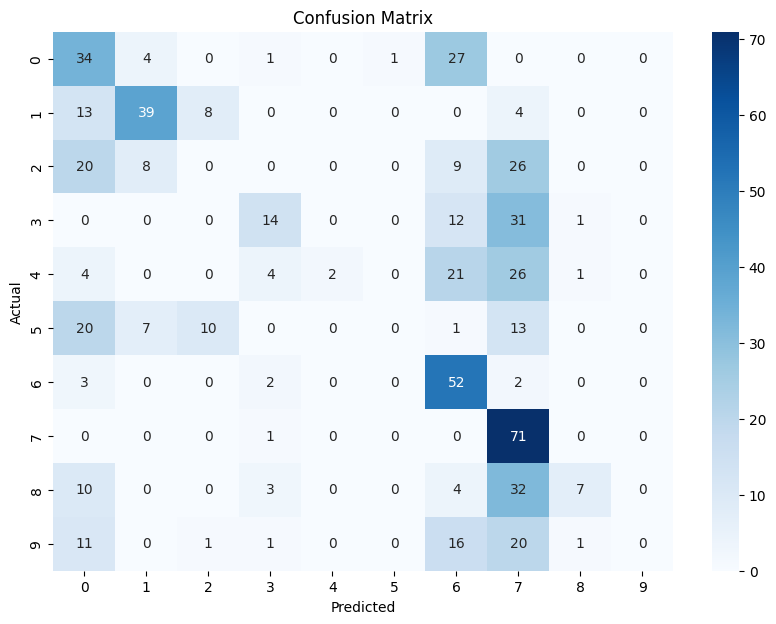


KNN results:
Accuracy for A1: 0.3996655518394649


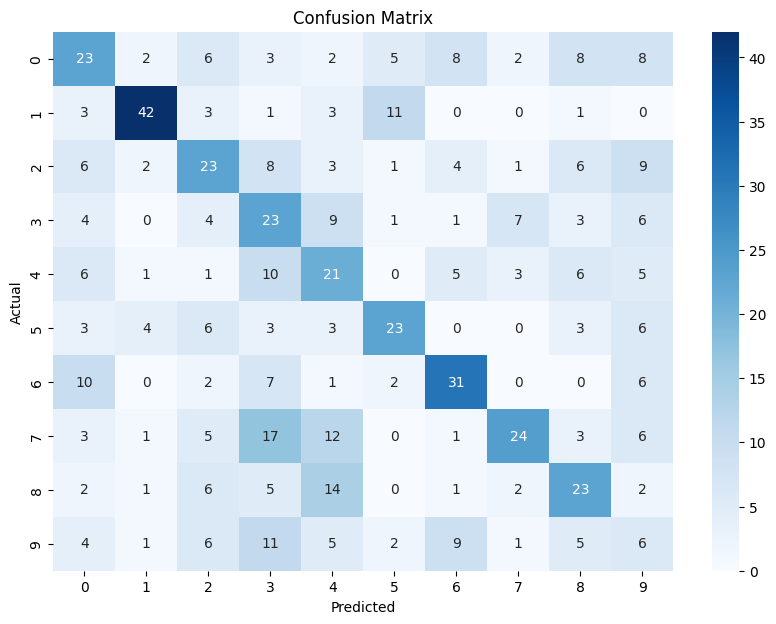

Accuracy for A2: 0.40468227424749165


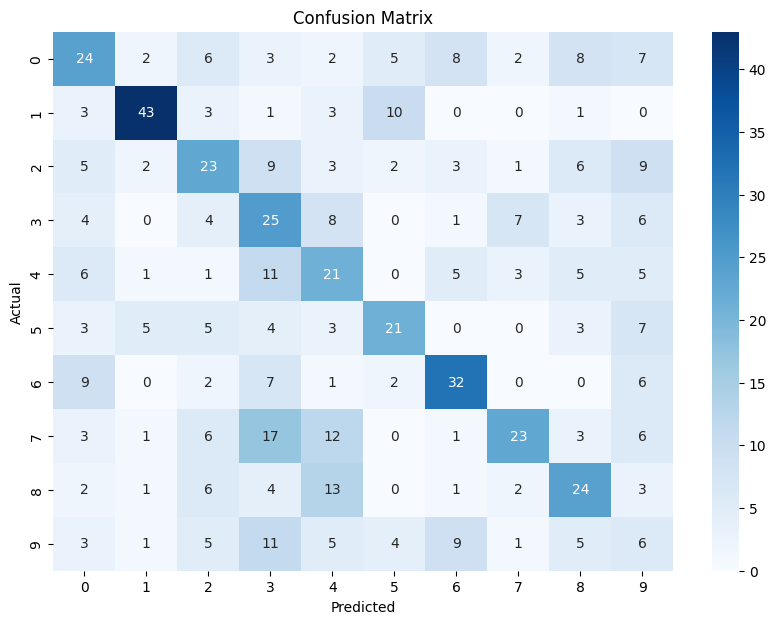

Accuracy for A3: 0.3963210702341137


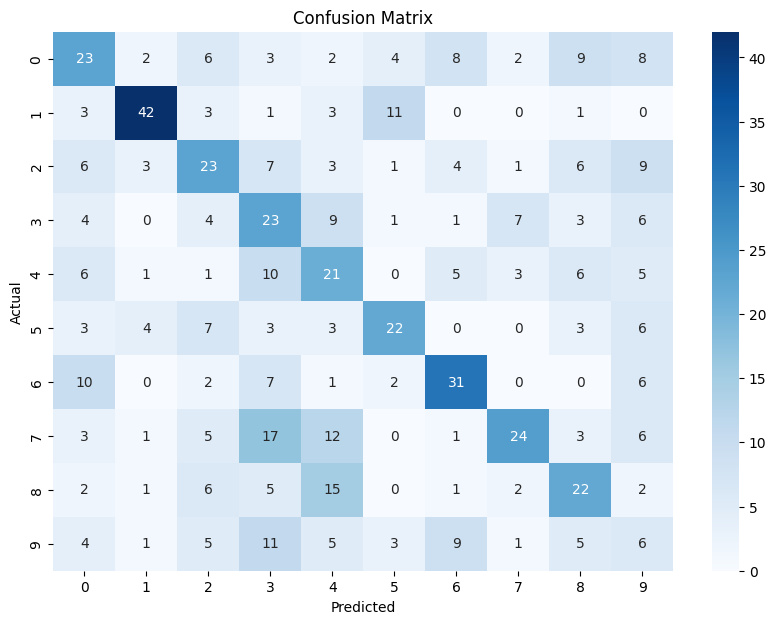

Accuracy for S1: 0.46488294314381273


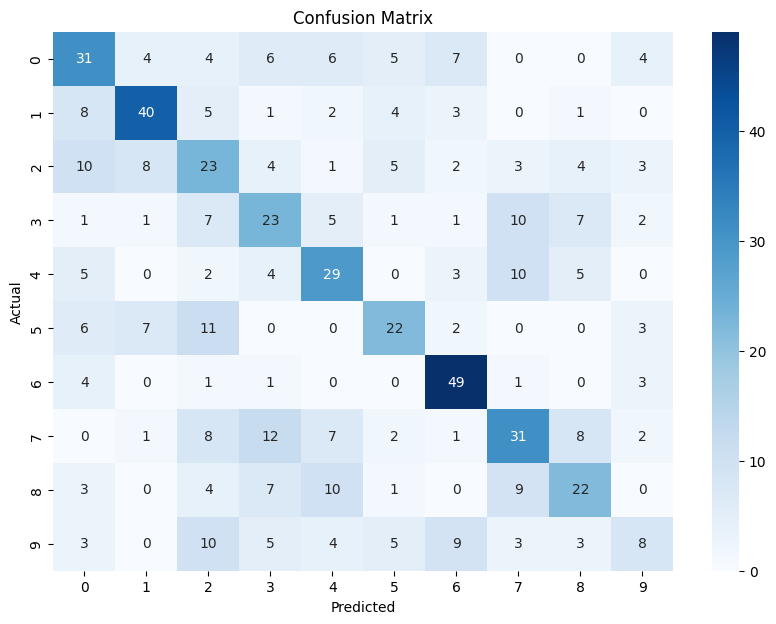

Accuracy for S2: 0.6053511705685619


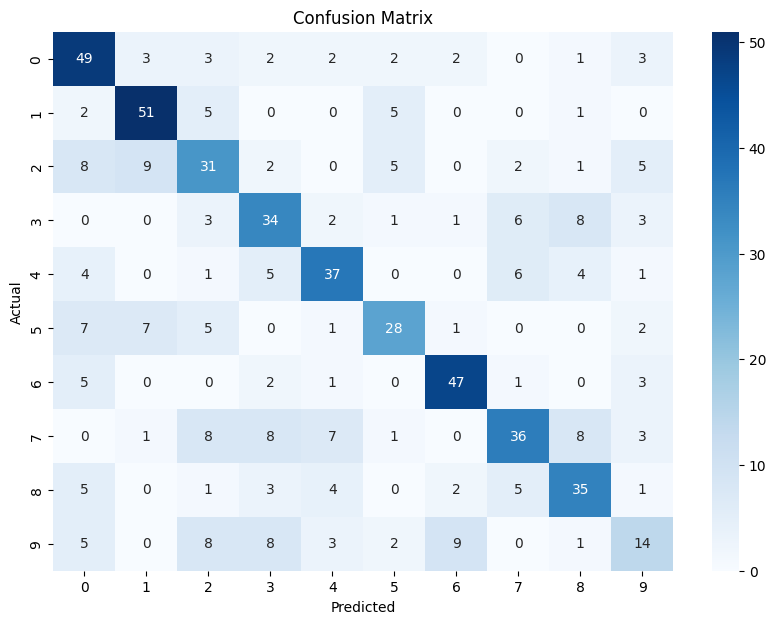

Accuracy for S3: 0.5752508361204013


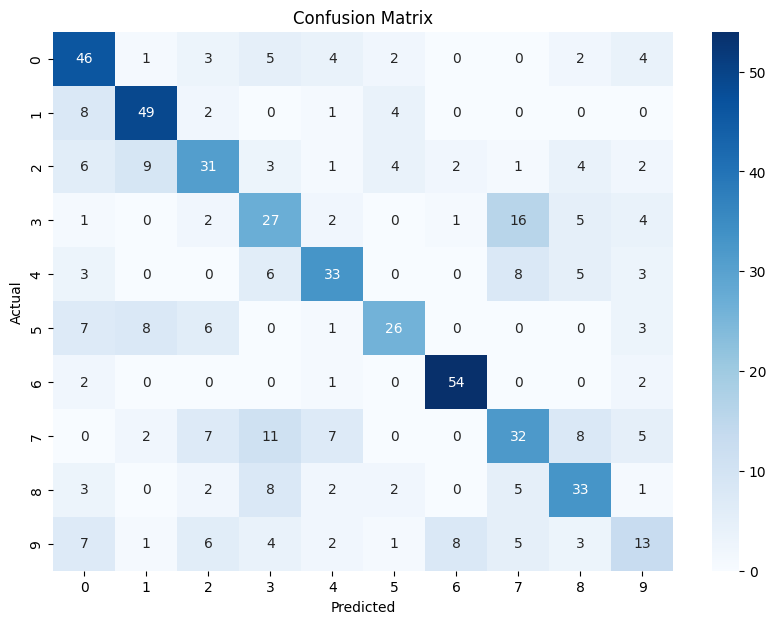

Accuracy for S4: 0.6053511705685619


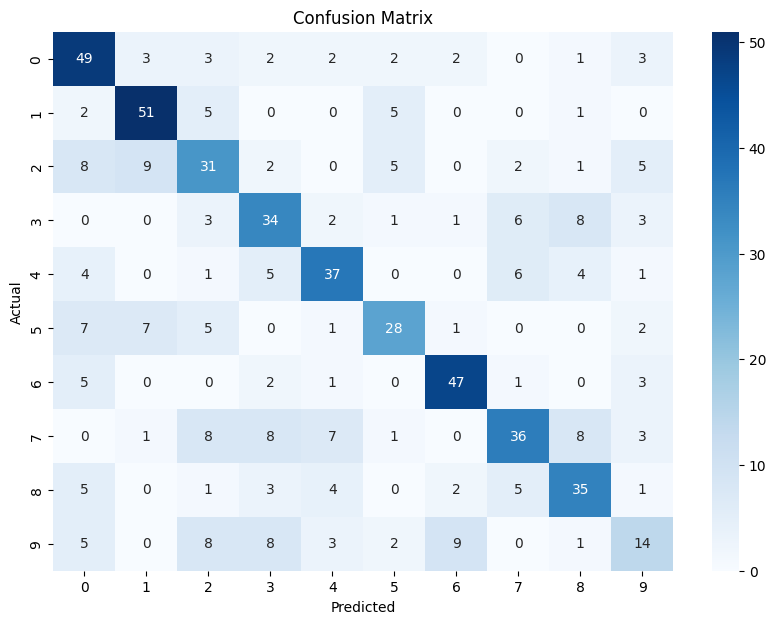

Accuracy for S6: 0.6053511705685619


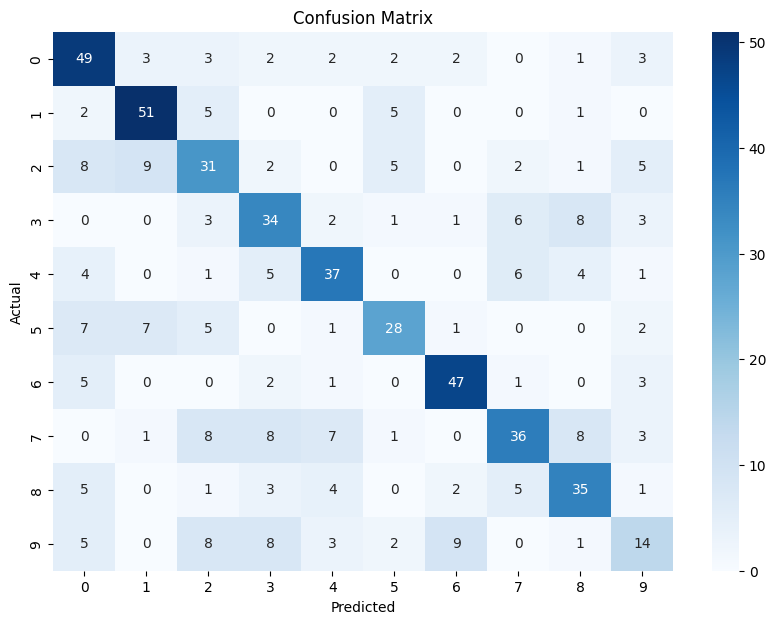

Accuracy for F1: 0.40301003344481606


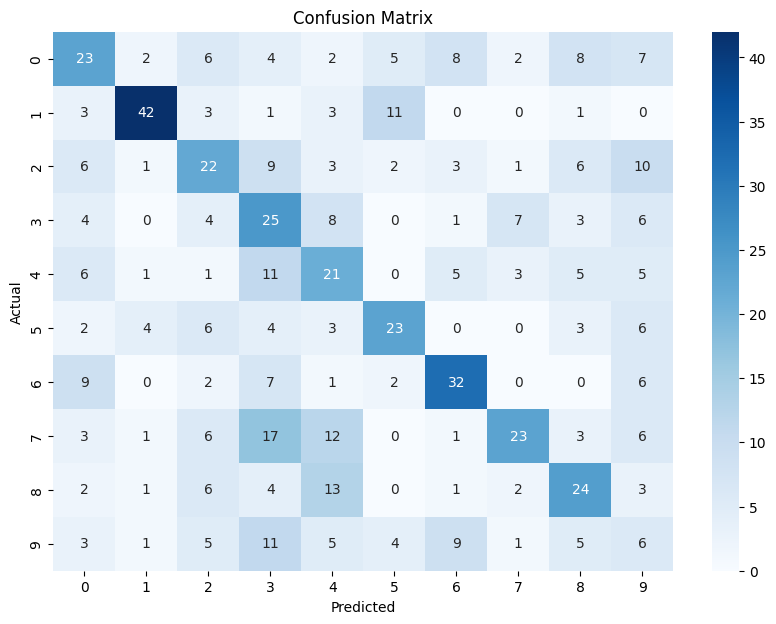

Accuracy for F2: 0.40301003344481606


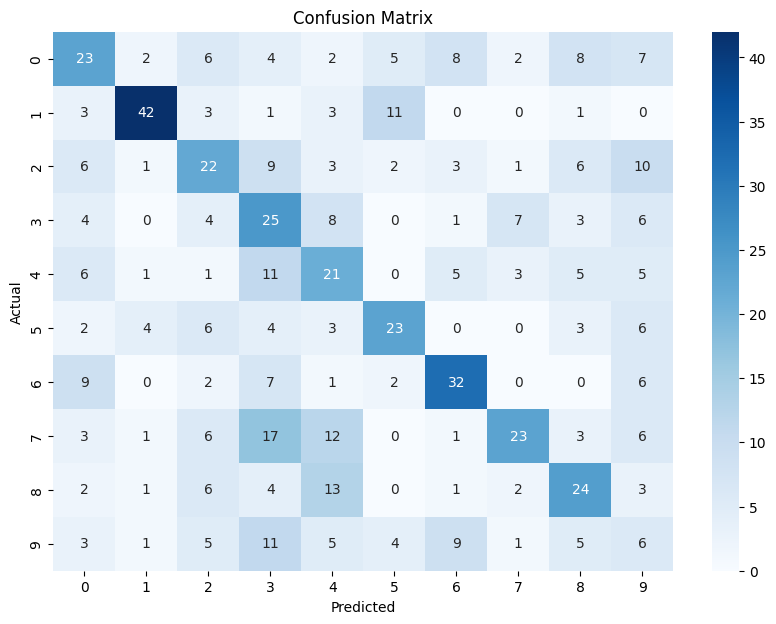

Accuracy for F4: 0.40301003344481606


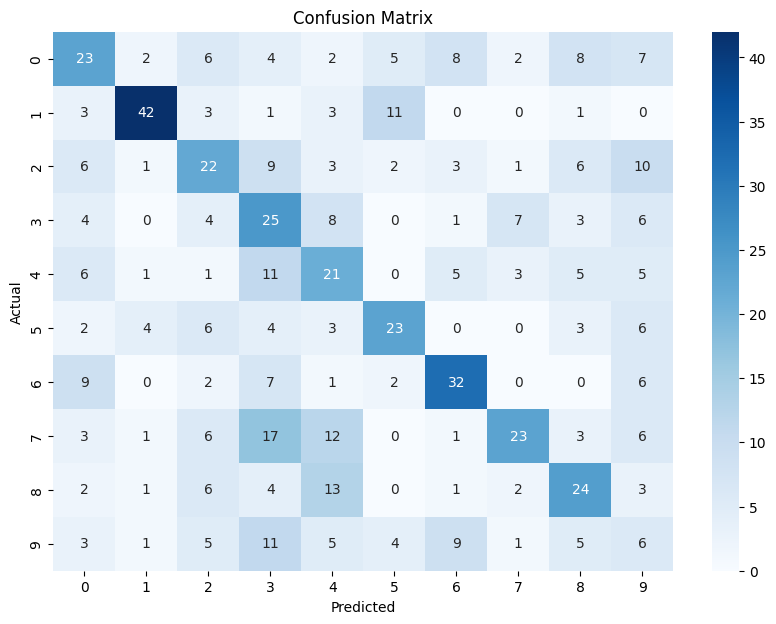

Accuracy for F5: 0.40635451505016723


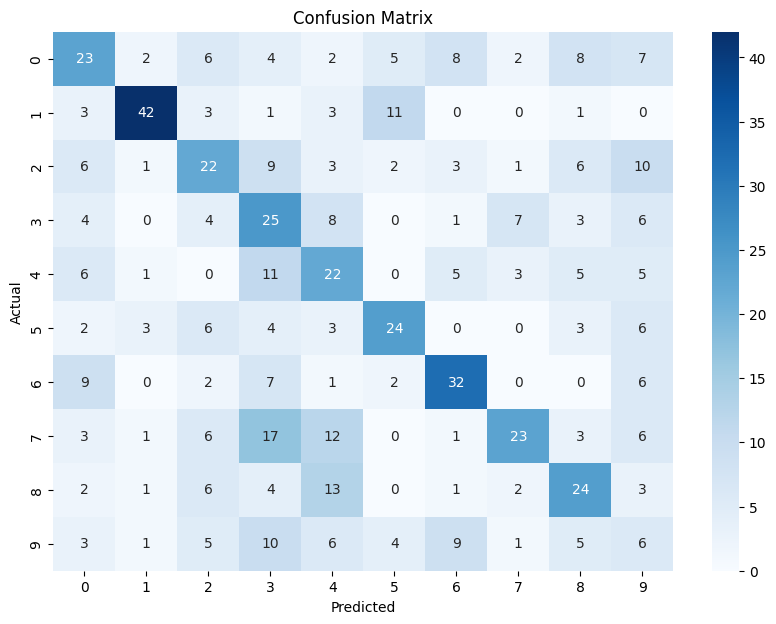

Accuracy for F6: 0.2625418060200669


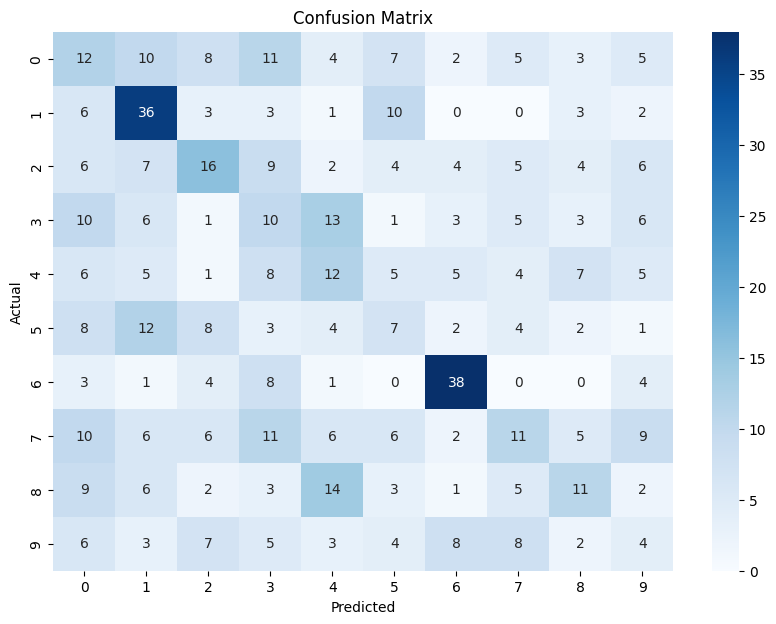

Accuracy for F8: 0.40468227424749165


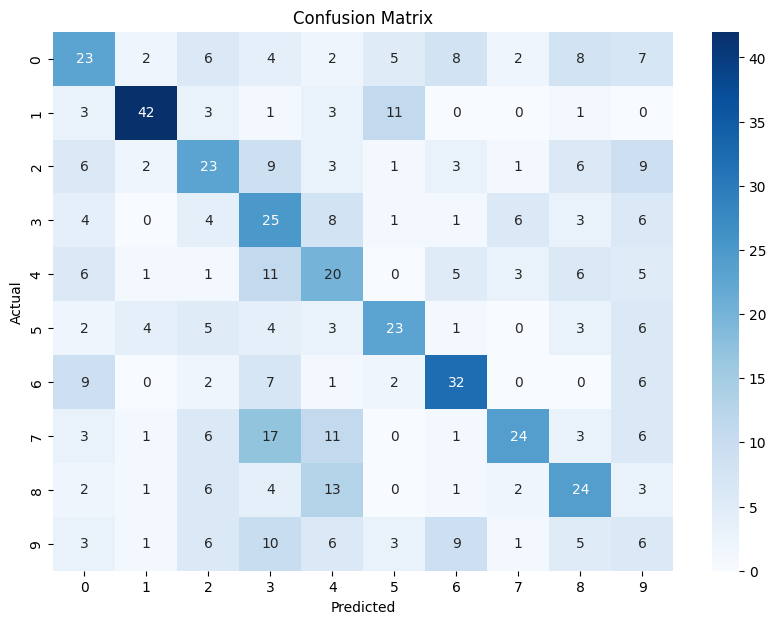

Accuracy for G1: 0.6036789297658863


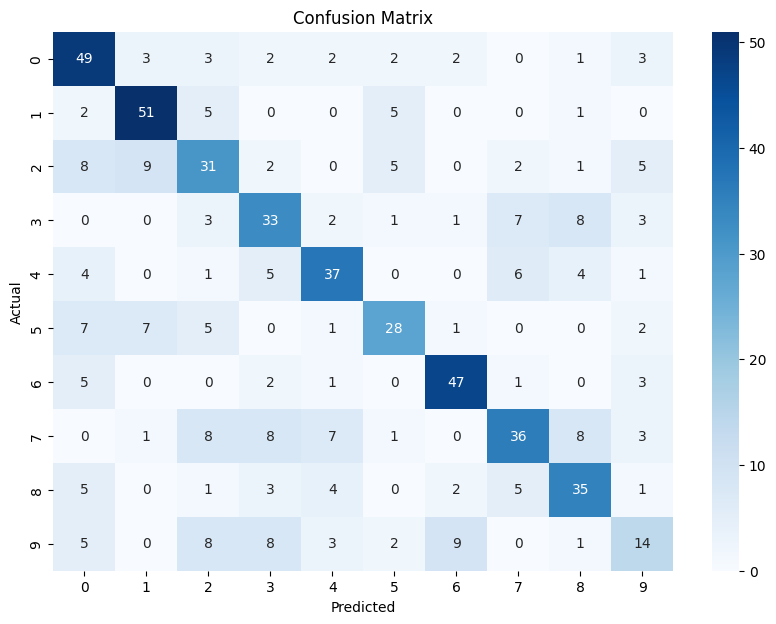

In [ ]:
print('SVM results:')
train_on_single_features(full_df, column_subsets, 'SVM')

print('\nKNN results:')
train_on_single_features(full_df, column_subsets, 'KNN')

## Homburg

In [ ]:
import pandas as pd

acoustic_feature_file = '/content/drive/MyDrive/Università/NAML_project/datasets_processed/homburg_acoustic_features.csv'
spectrum_feature_file = '/content/drive/MyDrive/Università/NAML_project/datasets_processed/homburg_spectrum_texture_features.csv'
aim_feature_file = '/content/drive/MyDrive/Università/NAML_project/datasets_processed/homburg_aim_texture_features.csv'

af = load_dataframe_from_csv(file_path = acoustic_feature_file)
sf = load_dataframe_from_csv(file_path = spectrum_feature_file)
aim = load_dataframe_from_csv(file_path = aim_feature_file)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
sf.columns = ['S-' + col if col not in ['label', 'label_1'] else col for col in sf.columns]
aim.columns = ['M-' + col if col not in ['label', 'label_1'] else col for col in aim.columns]

full_df = pd.merge(af, sf, on='label_1', how='inner')
full_df = full_df.drop(columns=['label_y'])
full_df = full_df.rename(columns={'label_x': 'label'})

full_df = pd.merge(full_df, aim, on='label_1', how='inner')
full_df = full_df.drop(columns=['label_y'])
full_df = full_df.rename(columns={'label_x': 'label'})

In [ ]:
full_df.head()

,label_1,label,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,...,M-LPQ500,M-LPQ501,M-LPQ502,M-LPQ503,M-LPQ504,M-LPQ505,M-LPQ506,M-LPQ507,M-LPQ508,M-LPQ509
0,raphiphop_1,raphiphop,166.436935,85.045486,14.686680,36.994850,14.541934,22.056189,10.625525,12.536690,...,0.0,0.0,4.173082,4.0,9.642655,4.0,5.470788,2.0,5.226481,4.0
1,raphiphop_2,raphiphop,103.146942,78.321671,12.822082,21.579224,0.290958,12.131853,0.305180,5.738511,...,0.0,0.0,3.929989,4.0,8.994409,4.0,6.636415,2.0,2.147314,4.0
2,raphiphop_3,raphiphop,221.876678,138.258102,55.977940,10.015645,12.944149,11.928767,10.596874,11.007463,...,0.0,0.0,4.740297,4.0,7.454825,4.0,5.546957,2.0,5.753180,4.0
3,raphiphop_4,raphiphop,98.780746,65.228271,12.641401,40.489437,18.354259,12.421285,8.737279,3.535683,...,0.0,0.0,4.092051,4.0,9.115955,4.0,5.762904,2.0,6.522972,4.0
4,raphiphop_5,raphiphop,133.033981,69.331665,21.453009,24.265600,12.431786,0.307681,6.126066,0.909496,...,0.0,0.0,3.605867,4.0,8.751317,4.0,6.260028,2.0,3.322259,4.0


SVM results:
Accuracy for A1: 0.35714285714285715


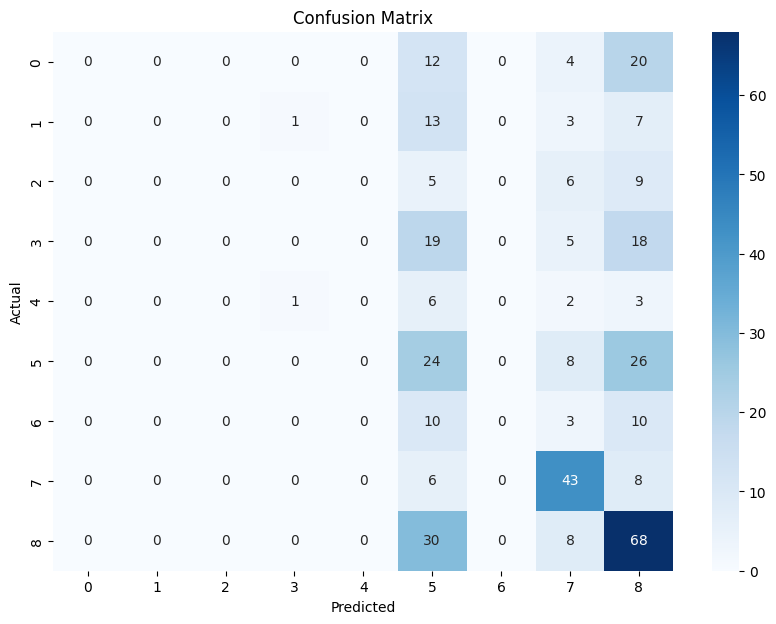

Accuracy for A2: 0.3544973544973545


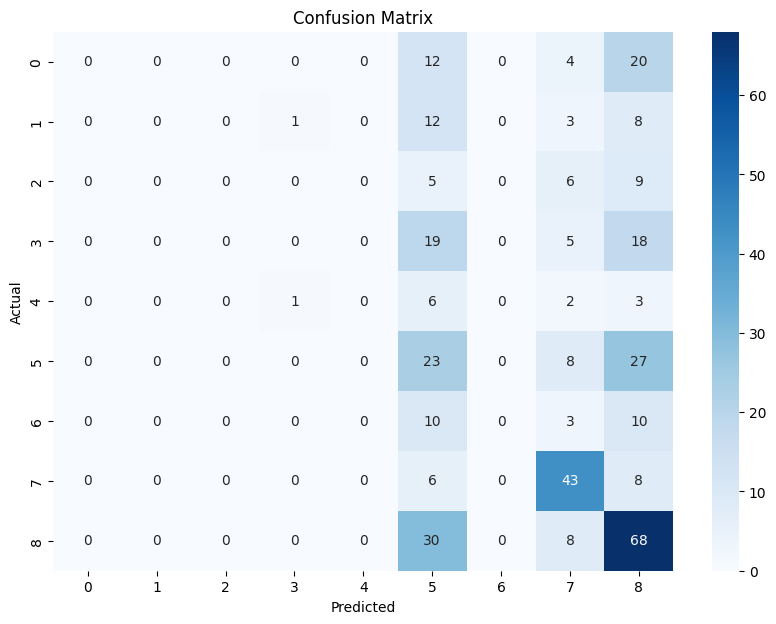

Accuracy for A3: 0.35714285714285715


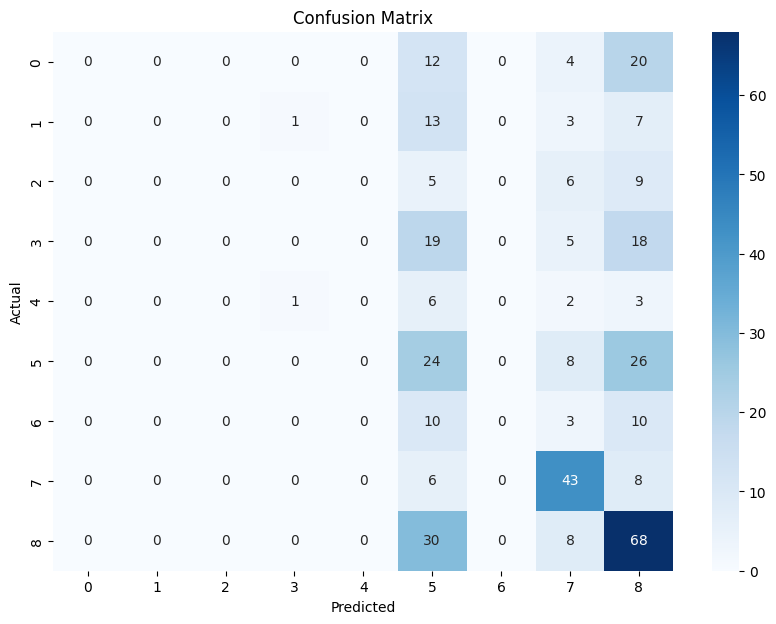

Accuracy for S1: 0.373015873015873


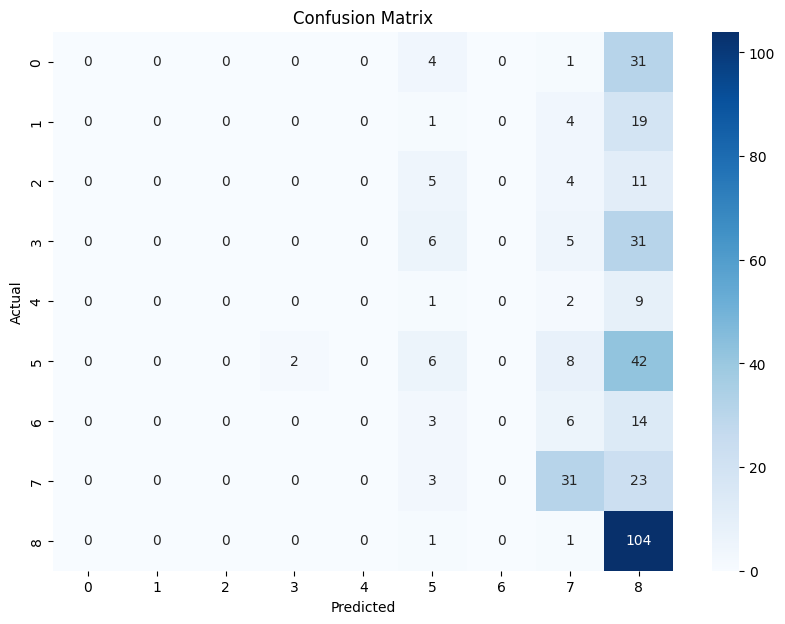

Accuracy for S2: 0.42063492063492064


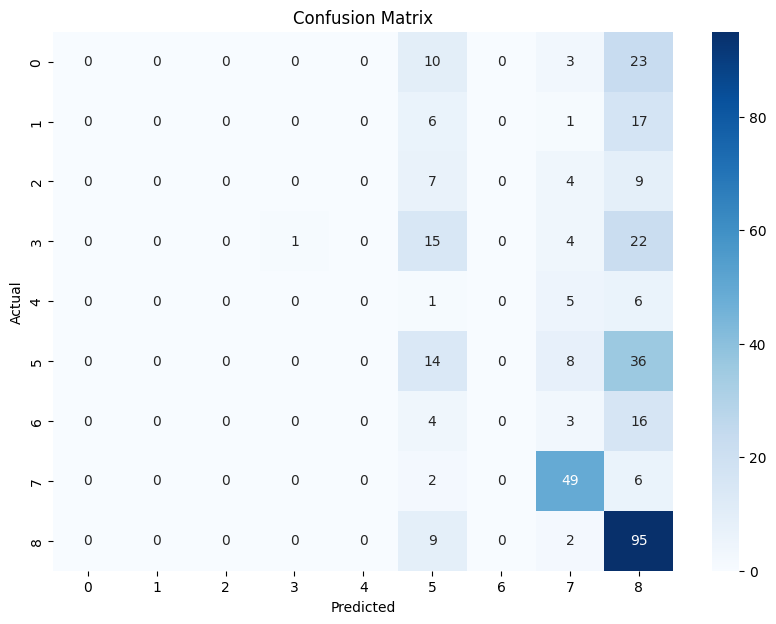

Accuracy for S3: 0.2830687830687831


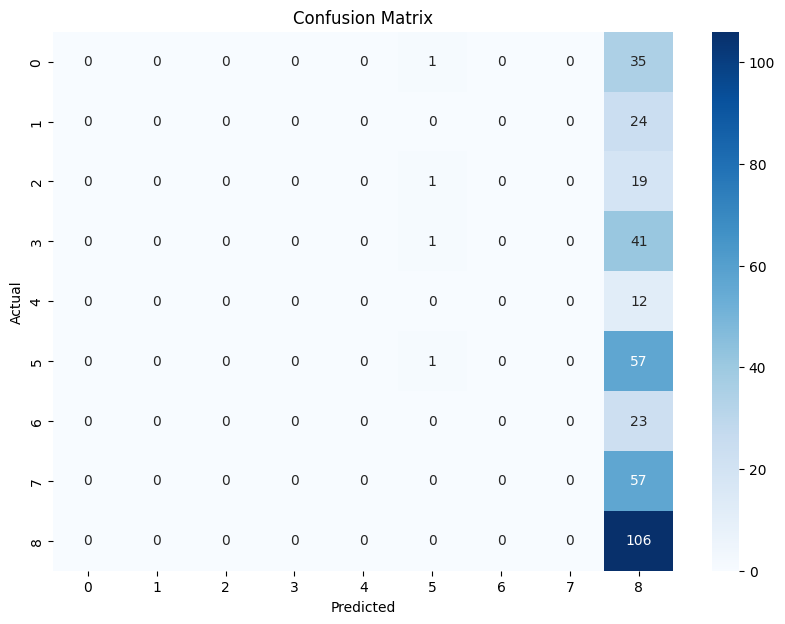

Accuracy for S4: 0.42063492063492064


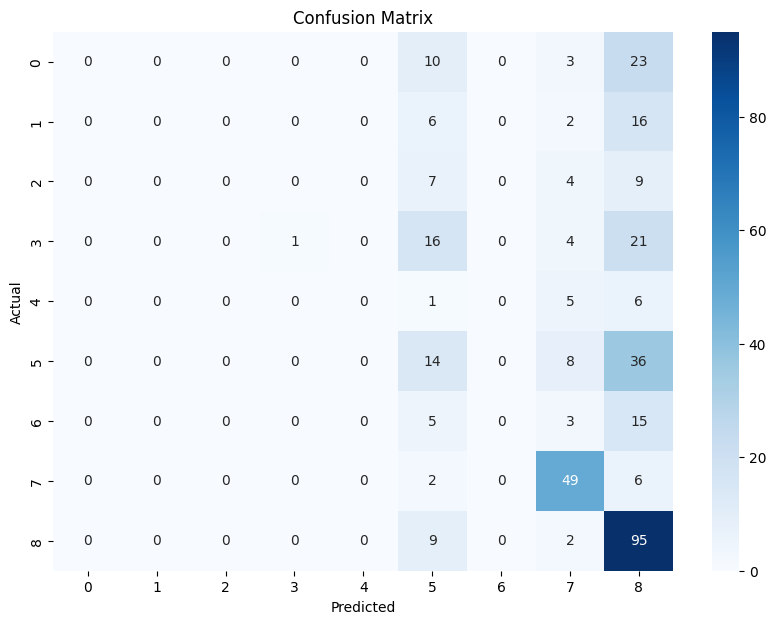

Accuracy for S6: 0.41798941798941797


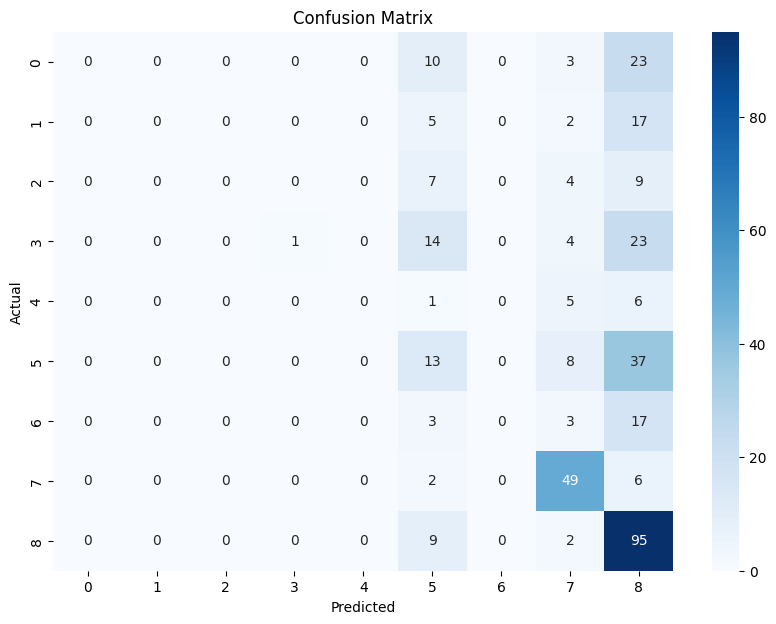

Accuracy for F1: 0.35714285714285715


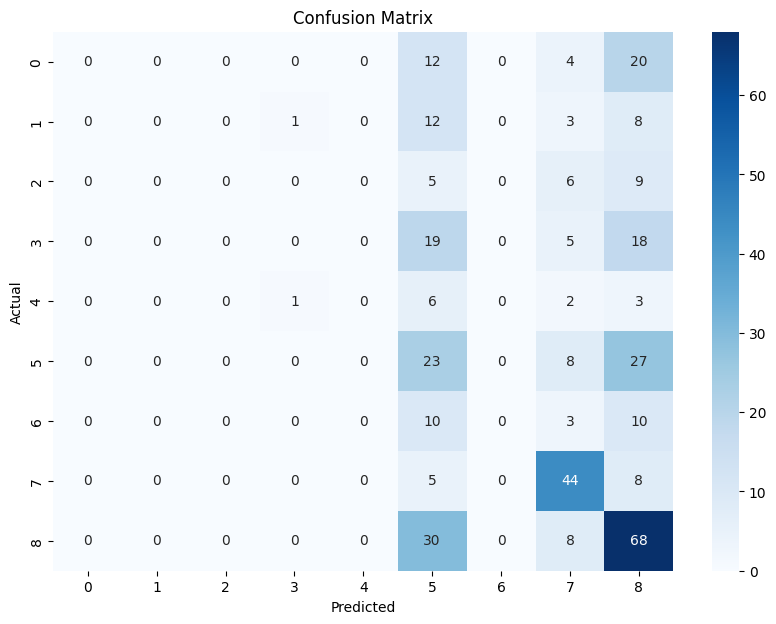

Accuracy for F2: 0.35714285714285715


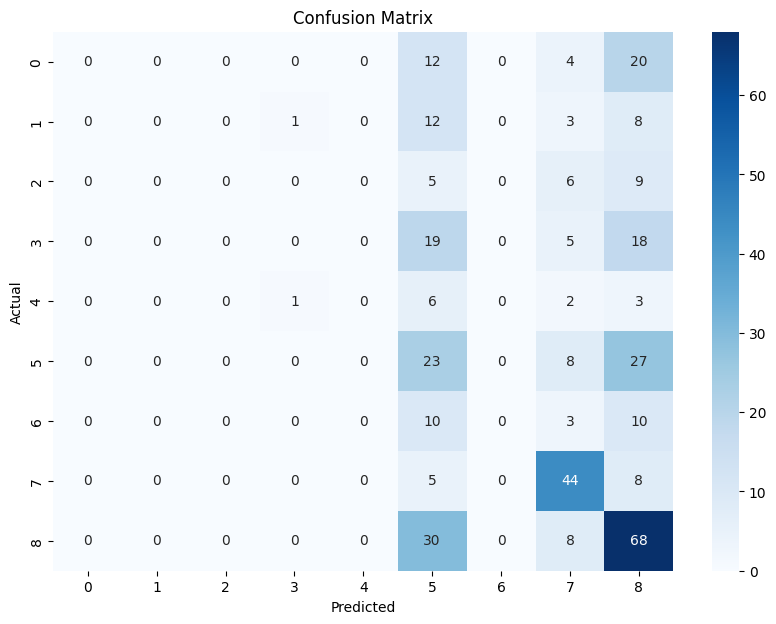

Accuracy for F4: 0.35714285714285715


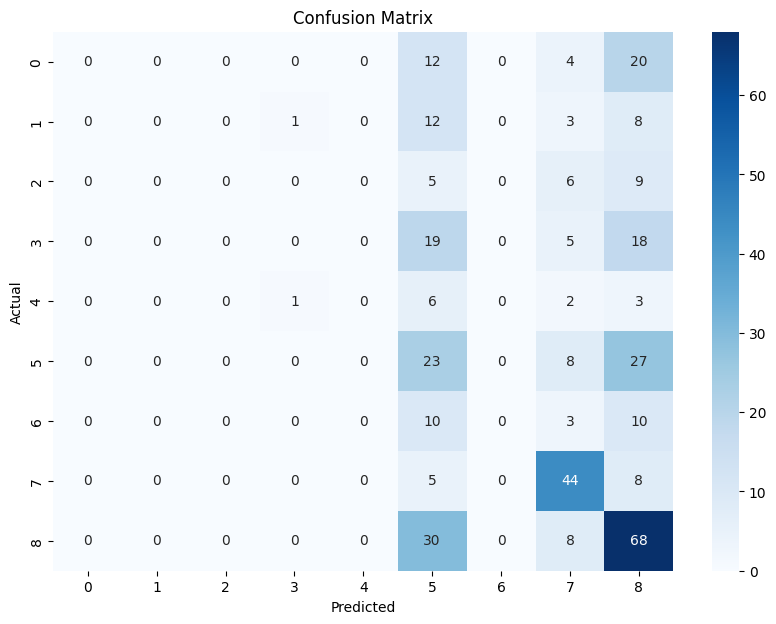

Accuracy for F5: 0.35714285714285715


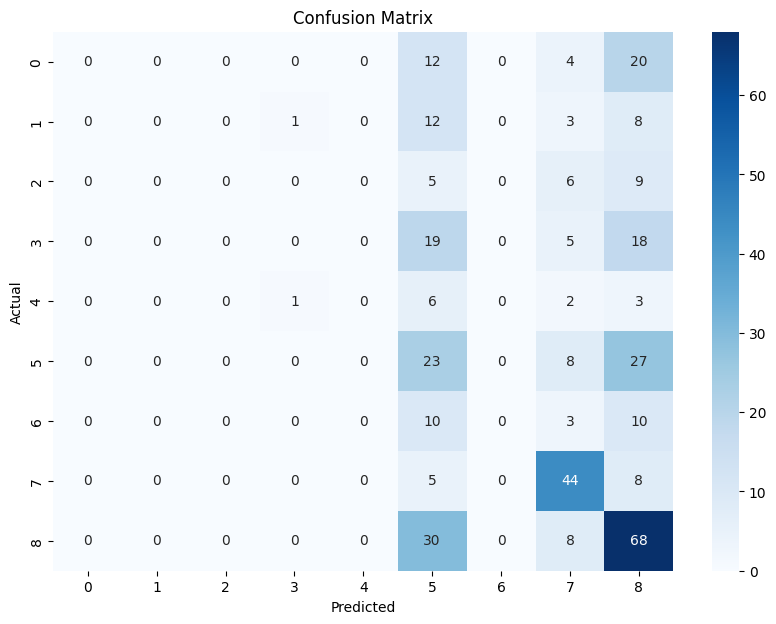

Accuracy for F6: 0.2804232804232804


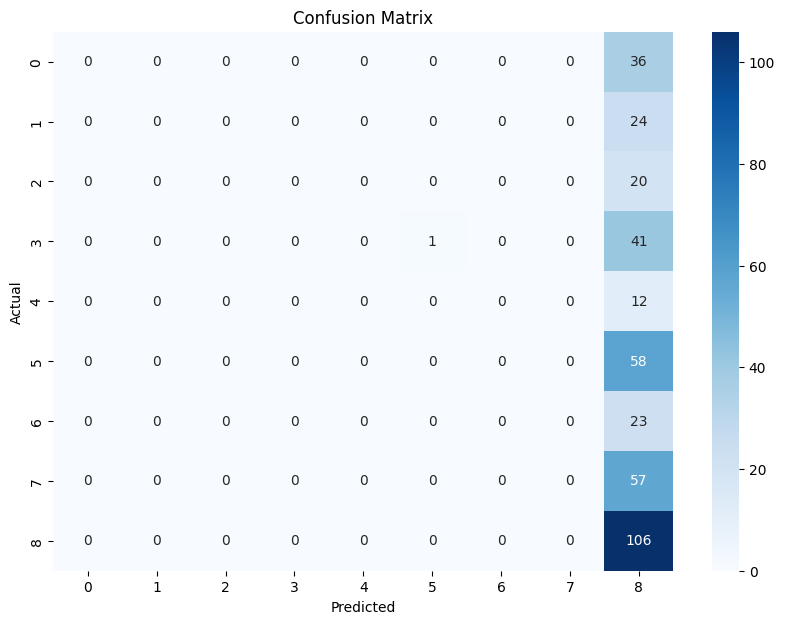

Accuracy for F8: 0.35714285714285715


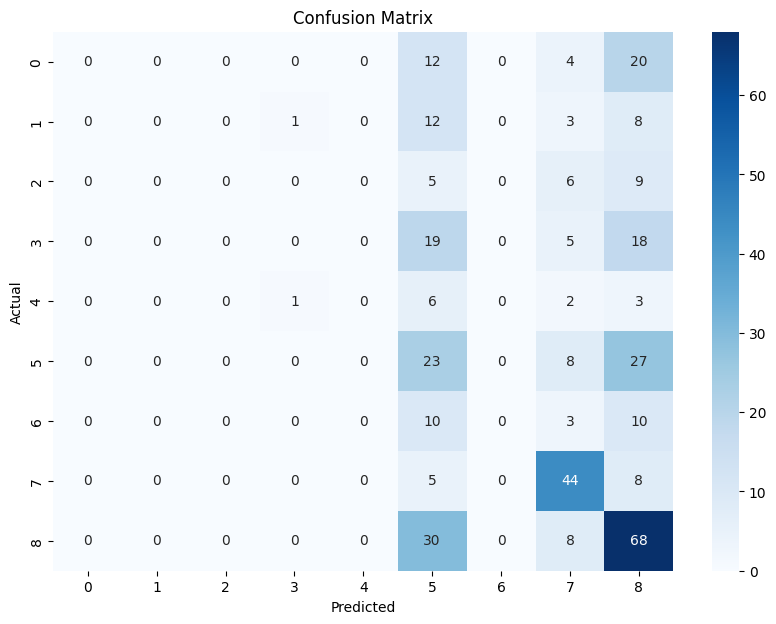

Accuracy for G1: 0.4126984126984127


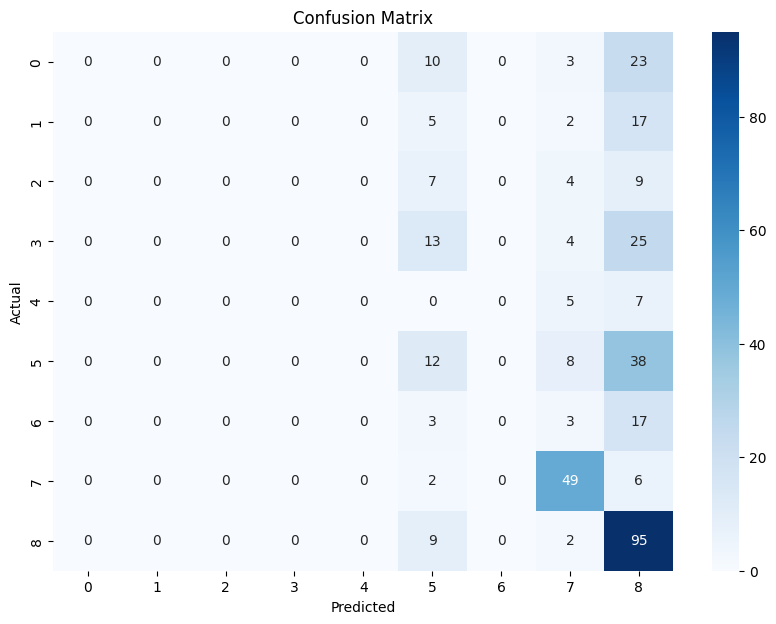


KNN results:
Accuracy for A1: 0.3783068783068783


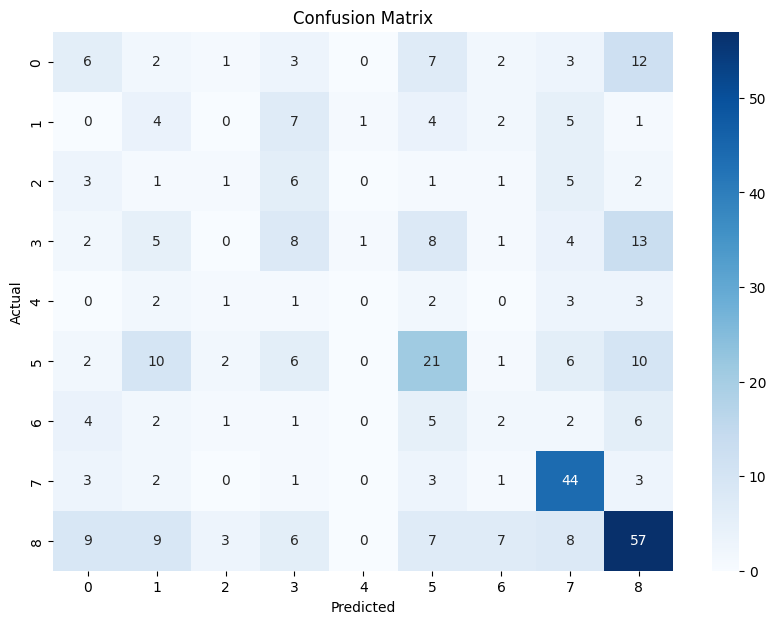

Accuracy for A2: 0.3783068783068783


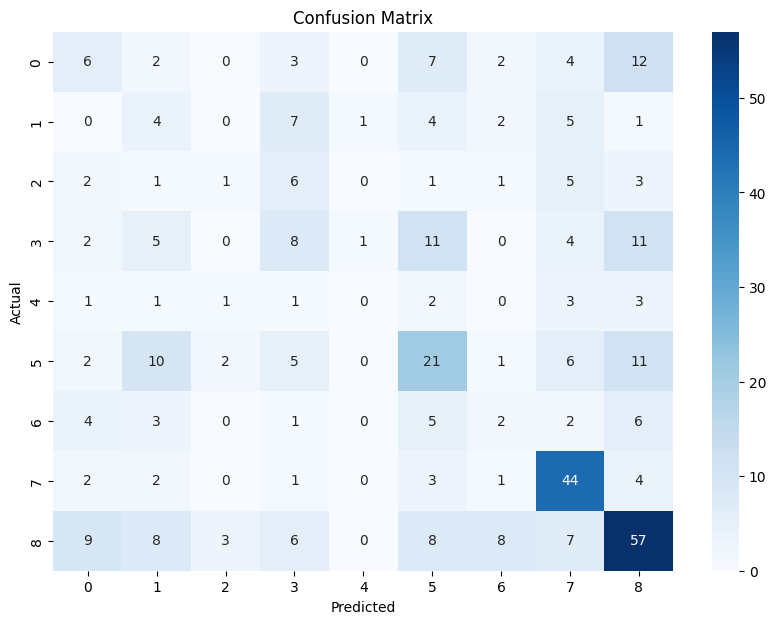

Accuracy for A3: 0.37566137566137564


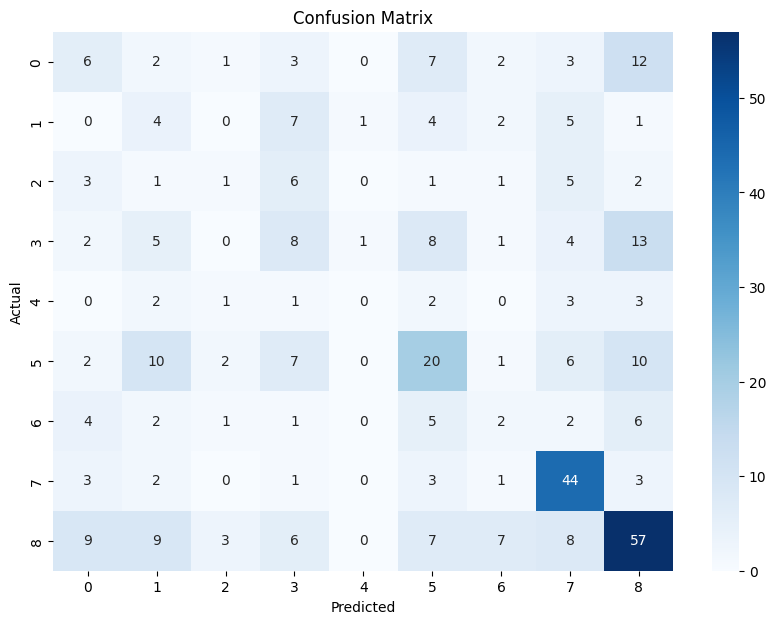

Accuracy for S1: 0.3994708994708995


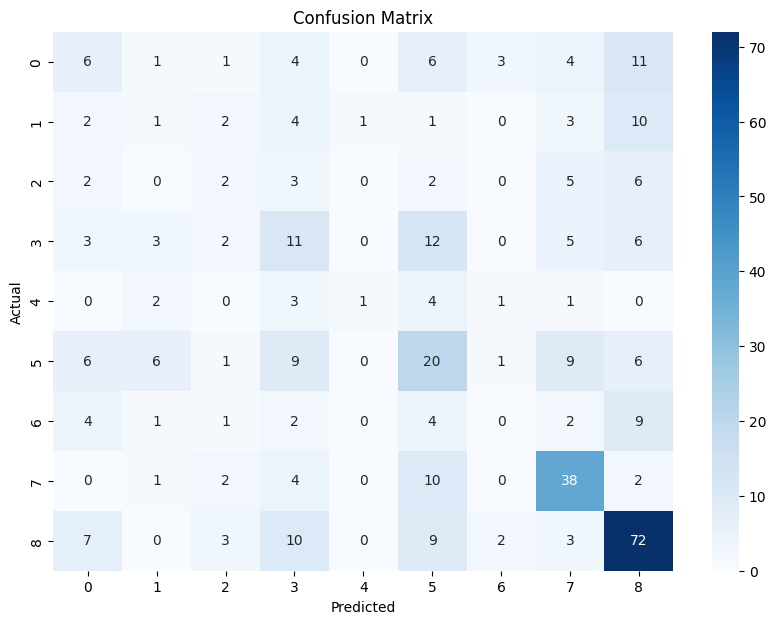

Accuracy for S2: 0.42857142857142855


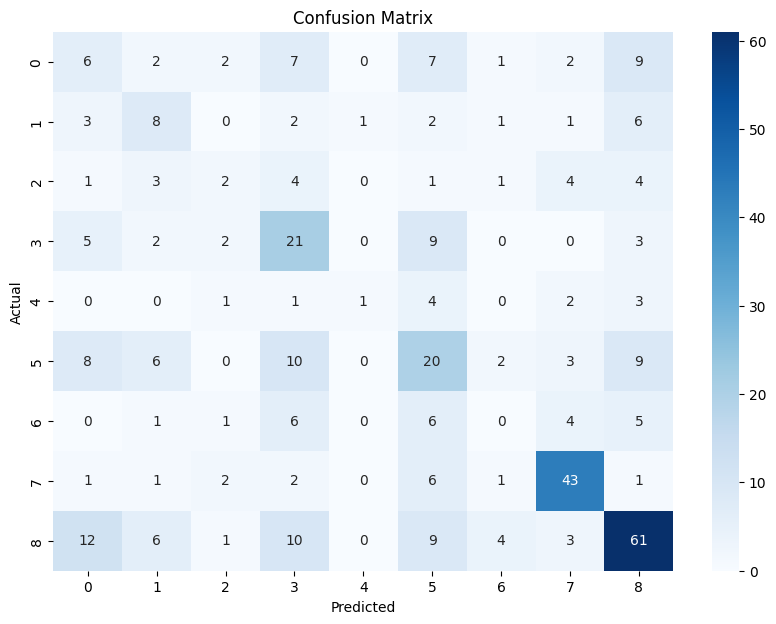

Accuracy for S3: 0.3941798941798942


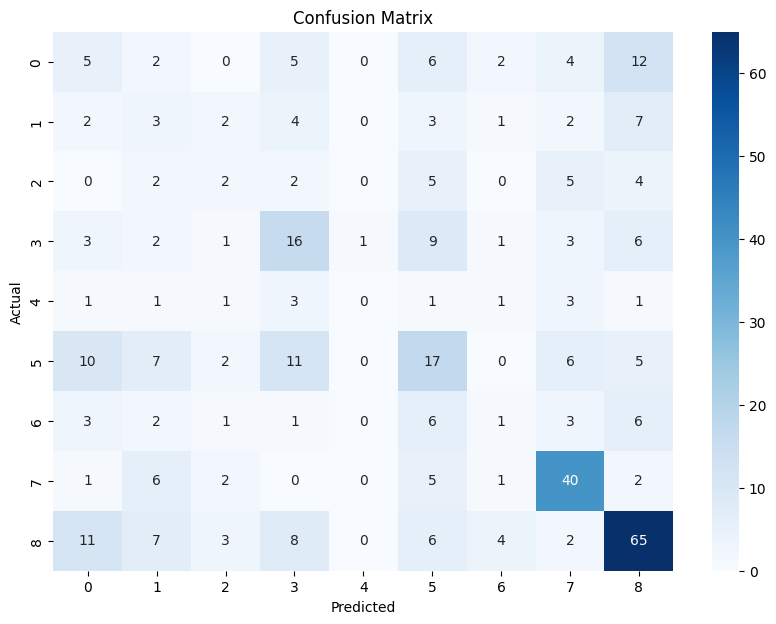

Accuracy for S4: 0.42857142857142855


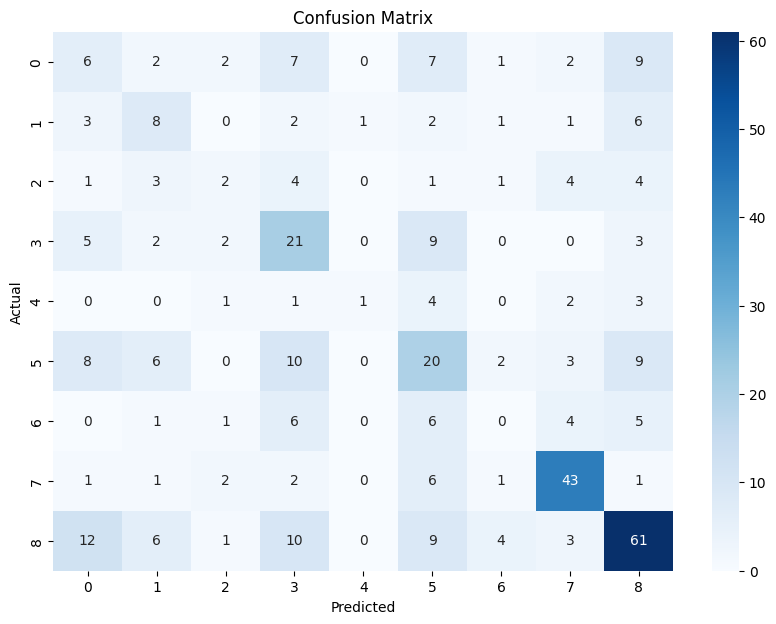

Accuracy for S6: 0.42857142857142855


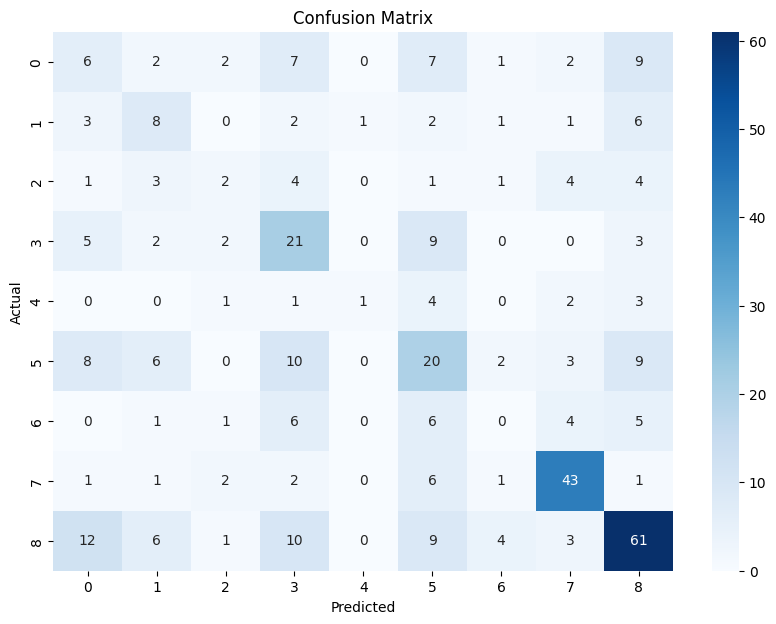

Accuracy for F1: 0.38095238095238093


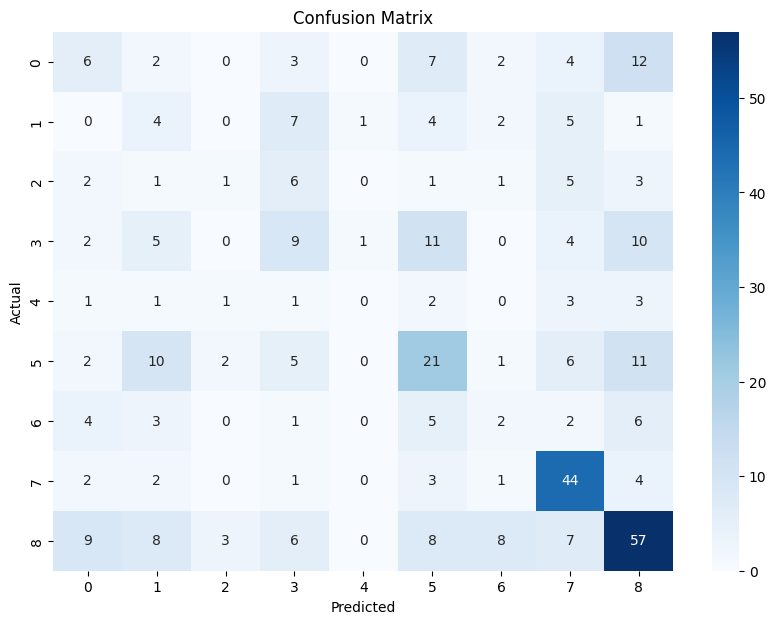

Accuracy for F2: 0.38095238095238093


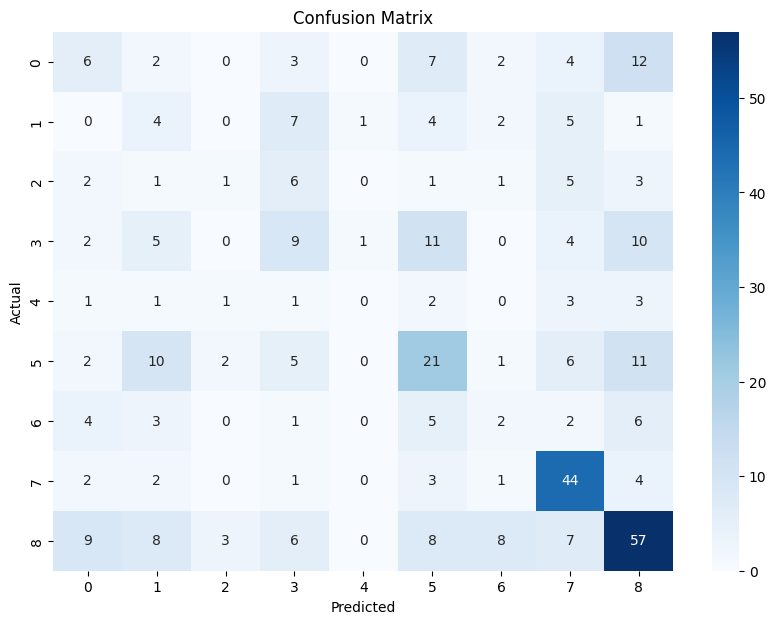

Accuracy for F4: 0.38095238095238093


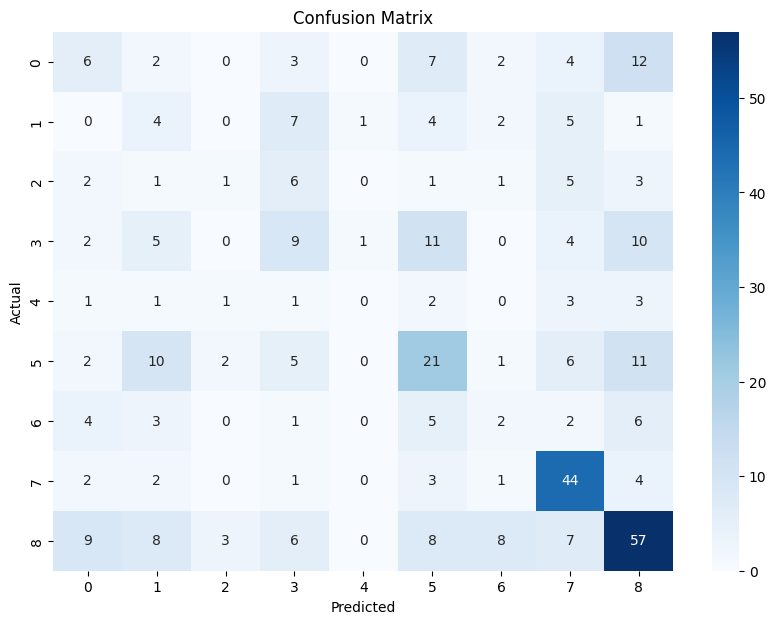

Accuracy for F5: 0.3835978835978836


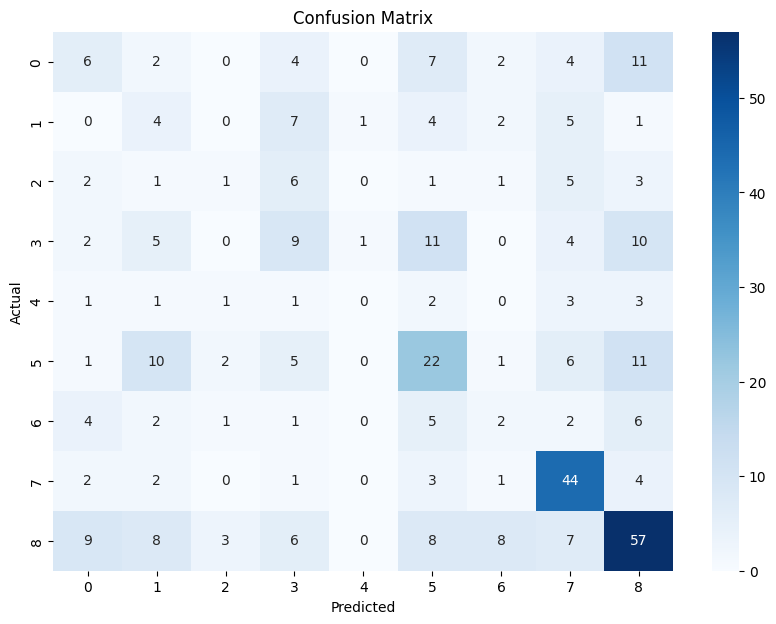

Accuracy for F6: 0.328042328042328


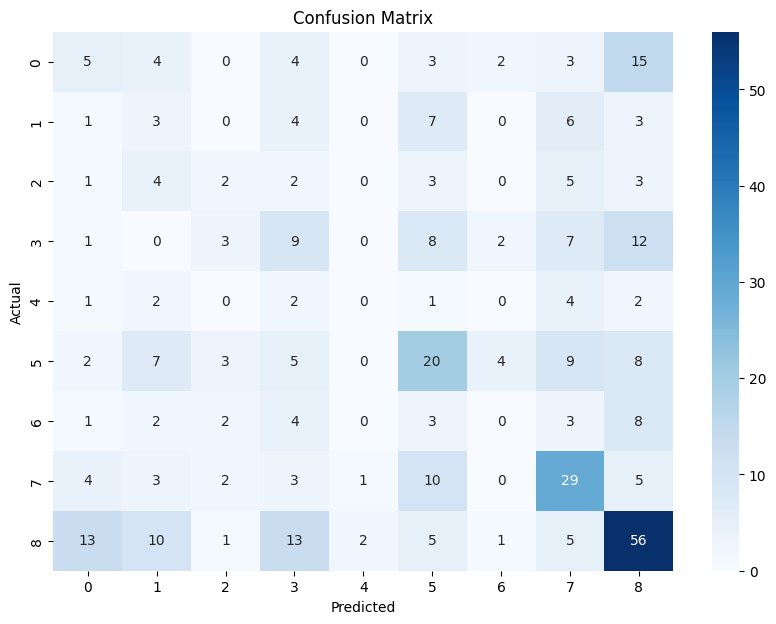

Accuracy for F8: 0.3835978835978836


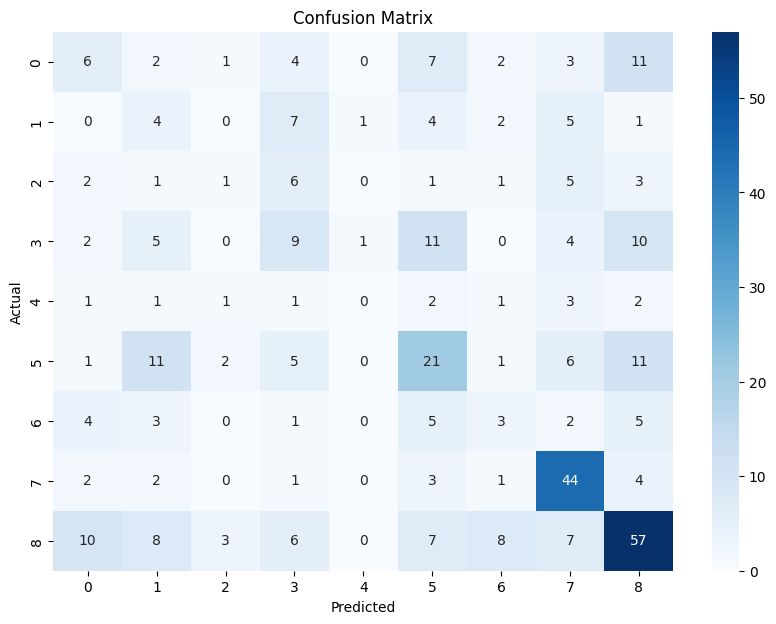

Accuracy for G1: 0.42857142857142855


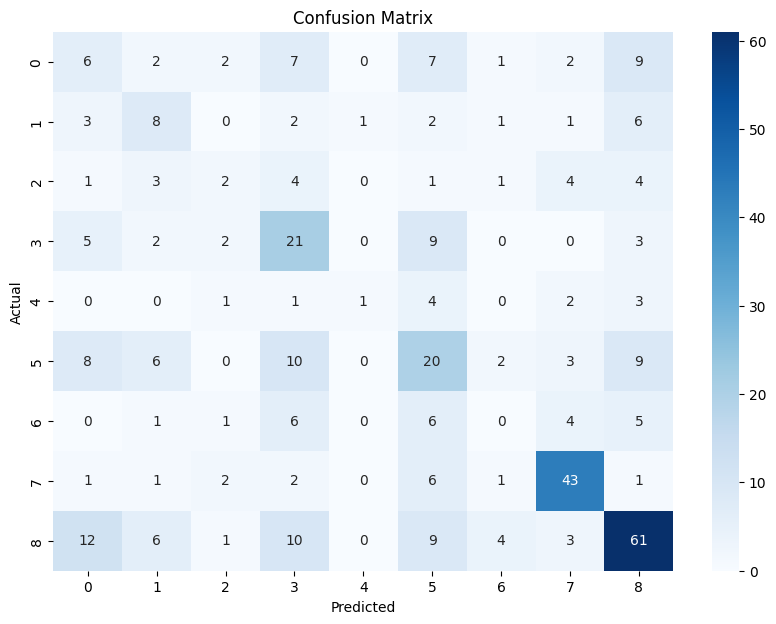

In [ ]:
print('SVM results:')
train_on_single_features(full_df, column_subsets, 'SVM')

print('\nKNN results:')
train_on_single_features(full_df, column_subsets, 'KNN')

## Ismir2004

In [ ]:
import pandas as pd

acoustic_feature_file = '/content/drive/MyDrive/Università/NAML_project/datasets_processed/ismir2004_acoustic_features.csv'
spectrum_feature_file = '/content/drive/MyDrive/Università/NAML_project/datasets_processed/ismir2004_spectrum_texture_features.csv'
aim_feature_file = '/content/drive/MyDrive/Università/NAML_project/datasets_processed/ismir2004_aim_texture_features.csv'

af = load_dataframe_from_csv(file_path = acoustic_feature_file)
sf = load_dataframe_from_csv(file_path = spectrum_feature_file)
aim = load_dataframe_from_csv(file_path = aim_feature_file)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
sf.columns = ['S-' + col if col not in ['label', 'label_1'] else col for col in sf.columns]
aim.columns = ['M-' + col if col not in ['label', 'label_1'] else col for col in aim.columns]

full_df = pd.merge(af, sf, on='label_1', how='inner')
full_df = full_df.drop(columns=['label_y'])
full_df = full_df.rename(columns={'label_x': 'label'})

full_df = pd.merge(full_df, aim, on='label_1', how='inner')
full_df = full_df.drop(columns=['label_y'])
full_df = full_df.rename(columns={'label_x': 'label'})

In [ ]:
af.head()

In [ ]:
sf.head()

In [ ]:
aim.head()

In [45]:
print(len(full_df))
full_df.head()

14502


,label_1,label,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,...,M-LPQ500,M-LPQ501,M-LPQ502,M-LPQ503,M-LPQ504,M-LPQ505,M-LPQ506,M-LPQ507,M-LPQ508,M-LPQ509
0,punk_1,punk,11.937013,71.134346,11.437682,25.586664,5.470666,3.337891,1.273769,2.269456,...,0.0,0.0,3.970505,4.0,1.073657,3.0,5.771818,2.0,3.241228,4.0
1,punk_2,punk,4.154061,74.897720,29.990070,32.053211,2.555988,5.343979,0.600543,11.464440,...,0.0,0.0,3.767928,4.0,9.359047,4.0,6.381979,2.0,3.362774,4.0
2,punk_3,punk,57.706036,79.464355,16.567841,30.480808,16.748726,10.144359,10.536179,15.474321,...,0.0,0.0,4.051536,4.0,1.041245,3.0,6.120655,2.0,4.092051,4.0
3,punk_4,punk,9.432040,72.167374,6.107736,38.649651,1.751942,4.940056,2.365243,9.691849,...,0.0,0.0,3.808443,4.0,9.521109,4.0,5.465116,2.0,5.955757,4.0
4,punk_5,punk,3.867364,76.601219,29.950989,31.261015,1.479375,6.771141,1.880208,11.360884,...,0.0,0.0,3.767928,4.0,8.305648,4.0,5.306701,2.0,6.847095,4.0


In [46]:
print(full_df['label'].unique())

['punk' 'pop' 'jazz' 'electronic' 'world' 'classical' 'metal' 'rock']


In [47]:
print(len(full_df[full_df['label'] == 'punk']))
print(len(full_df[full_df['label'] == 'pop']))
print(len(full_df[full_df['label'] == 'jazz']))
print(len(full_df[full_df['label'] == 'electronic']))
print(len(full_df[full_df['label'] == 'world']))
print(len(full_df[full_df['label'] == 'classical']))
print(len(full_df[full_df['label'] == 'metal']))
print(len(full_df[full_df['label'] == 'rock']))

256
161
584
3667
1833
5087
849
2065


In [49]:
print(len(full_df))
full_df_cut = filter_dataframe(full_df)
print(len(full_df_cut))

14502
4501


SVM results:
Accuracy for A1: 0.4095449500554939


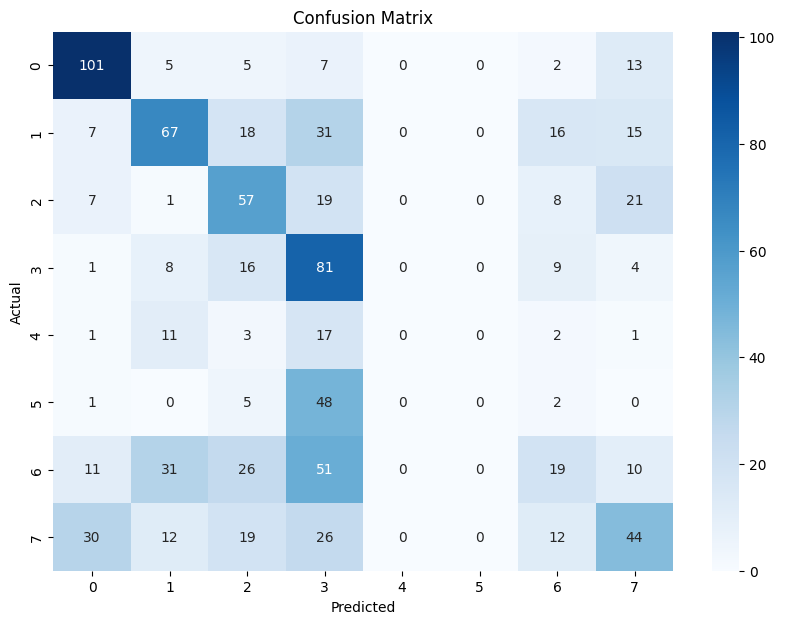

Accuracy for A2: 0.4095449500554939


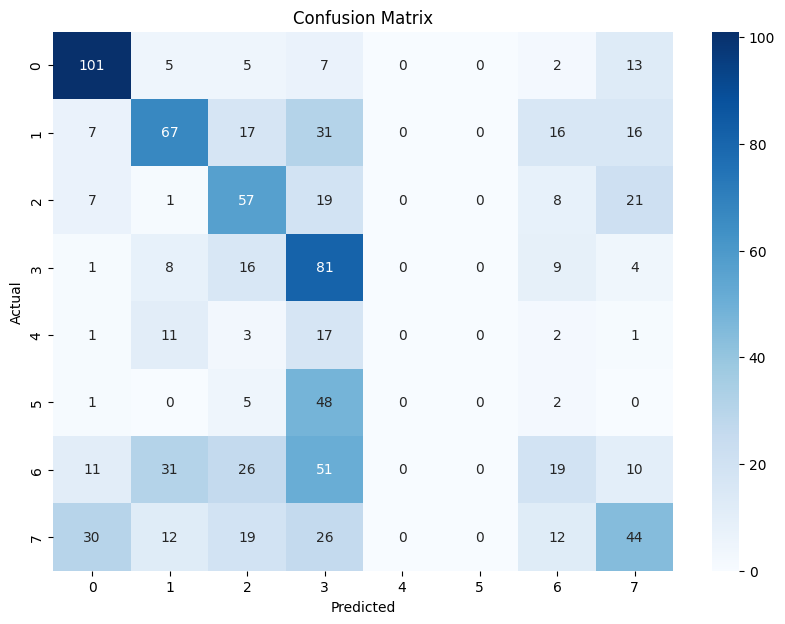

Accuracy for A3: 0.4095449500554939


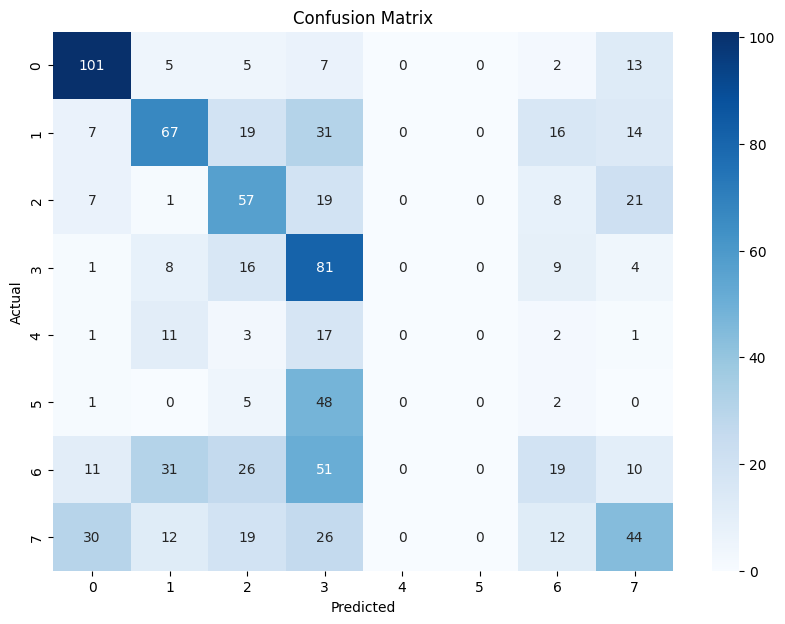

Accuracy for S1: 0.28412874583795783


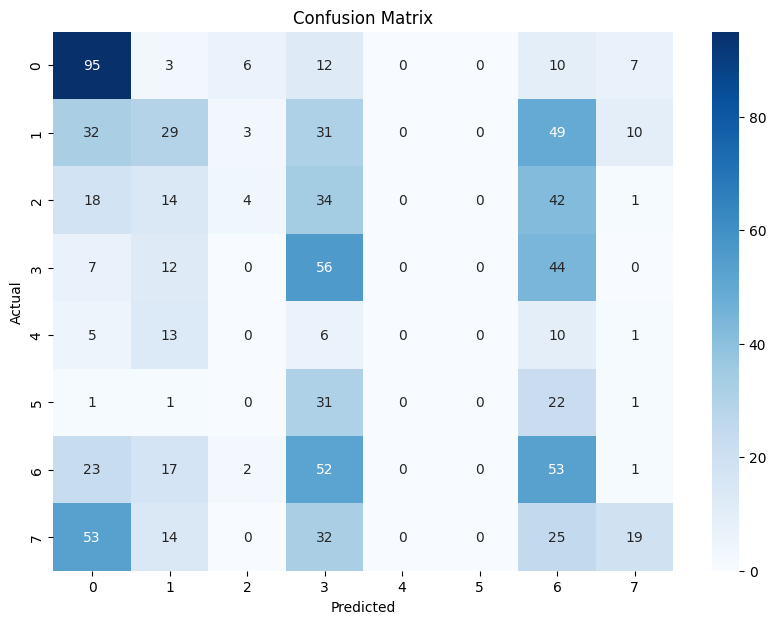

Accuracy for S2: 0.3895671476137625


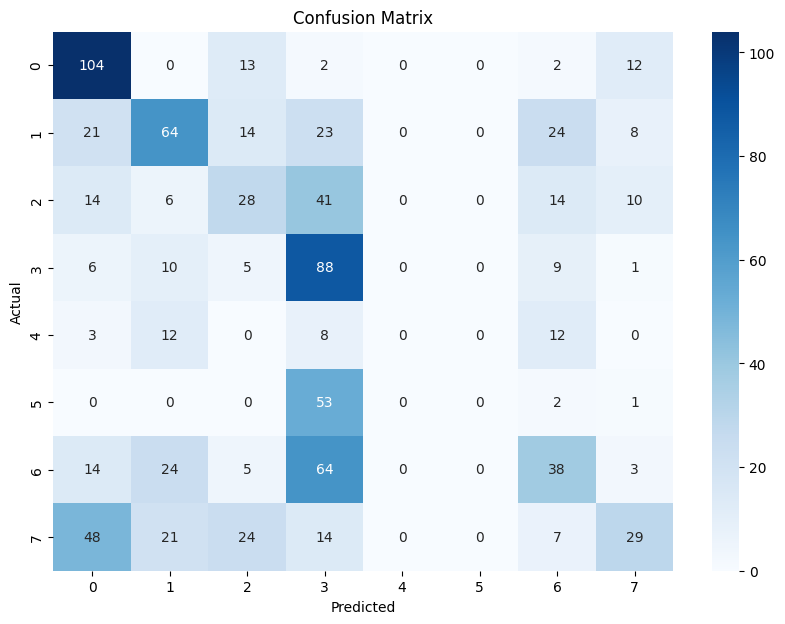

Accuracy for S3: 0.1753607103218646


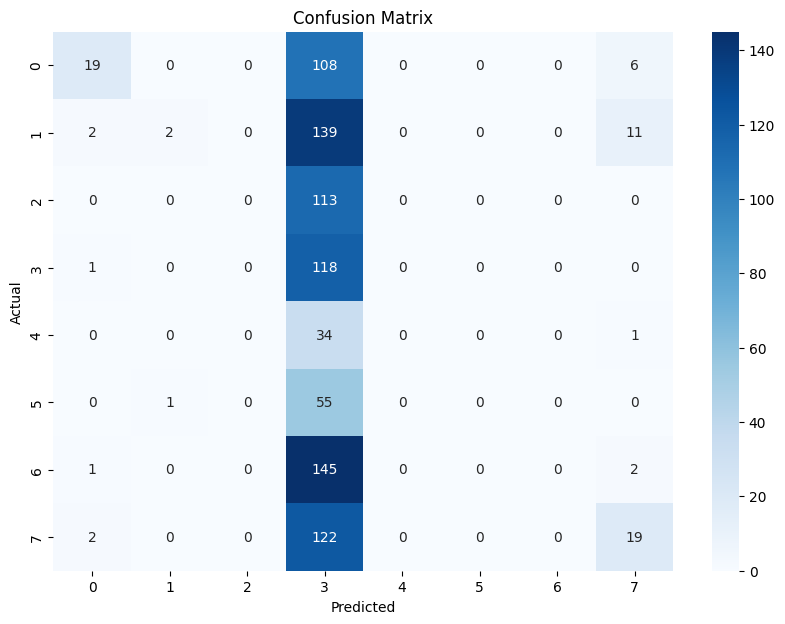

Accuracy for S4: 0.3895671476137625


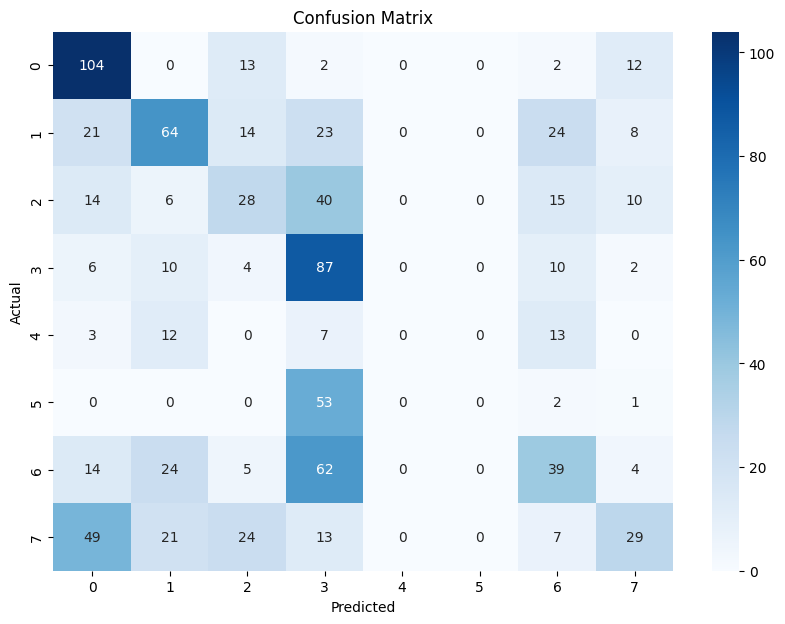

Accuracy for S6: 0.39289678135405104


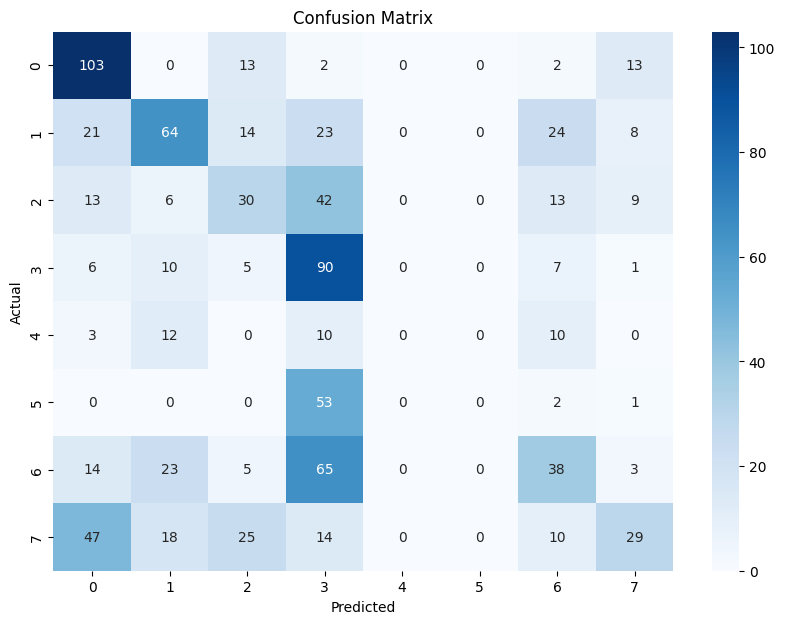

Accuracy for F1: 0.4095449500554939


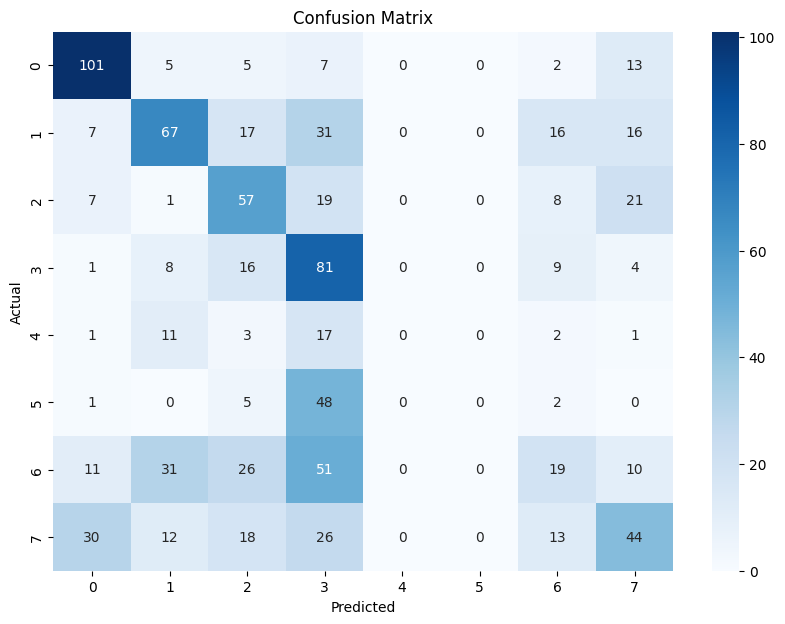

Accuracy for F2: 0.4095449500554939


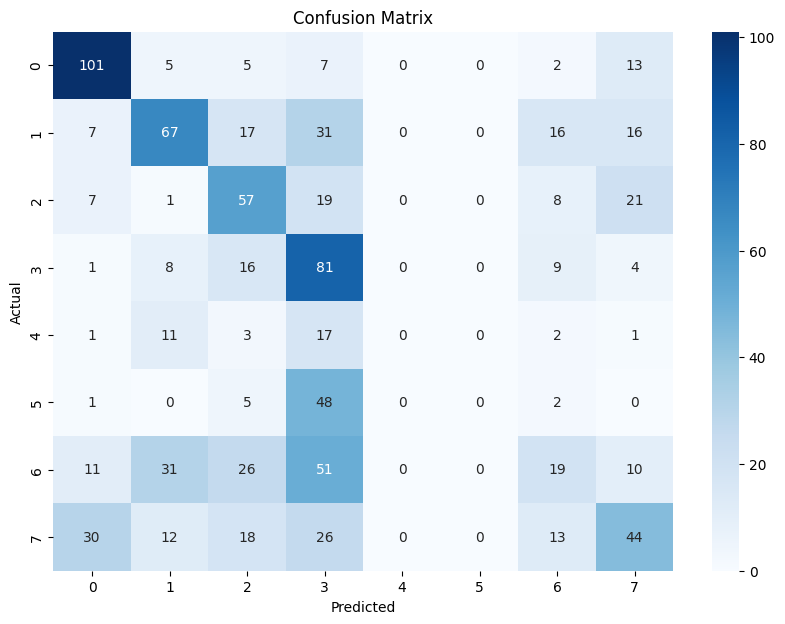

Accuracy for F4: 0.4095449500554939


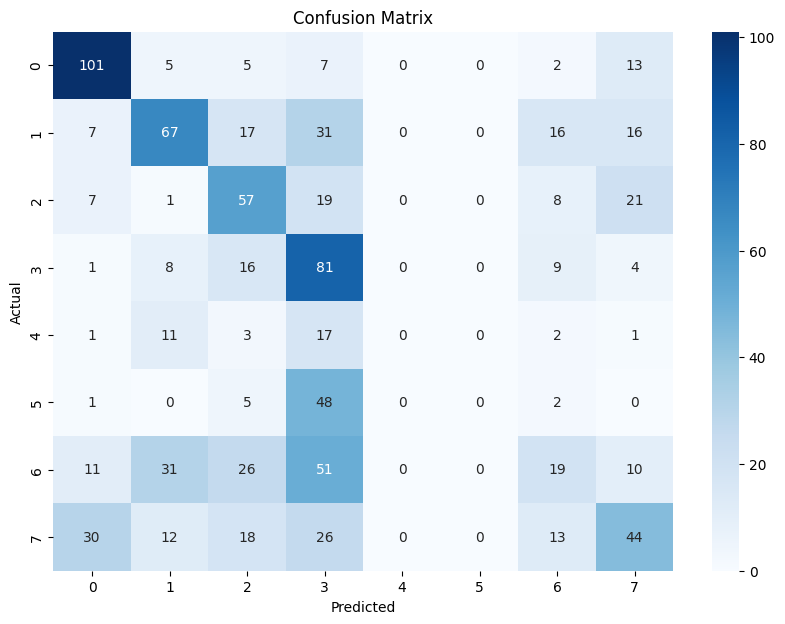

Accuracy for F5: 0.4095449500554939


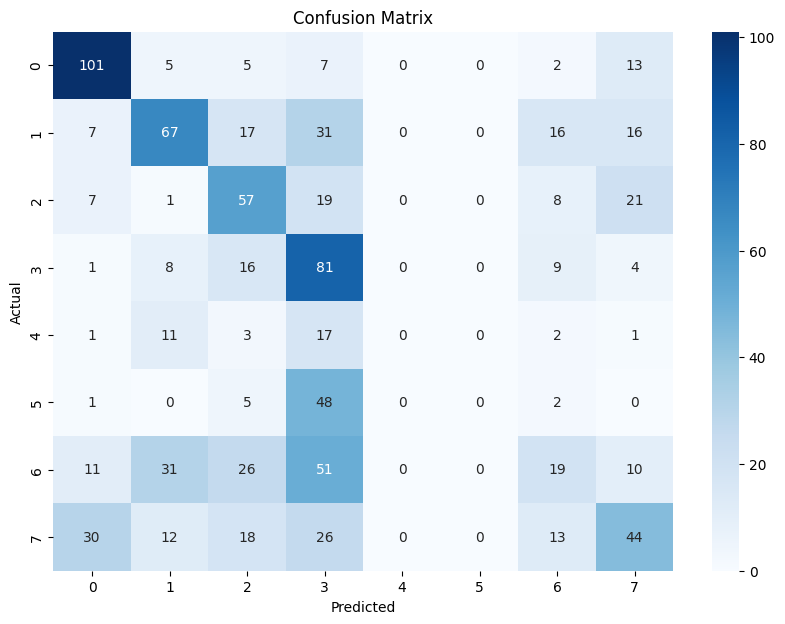

Accuracy for F6: 0.14095449500554938


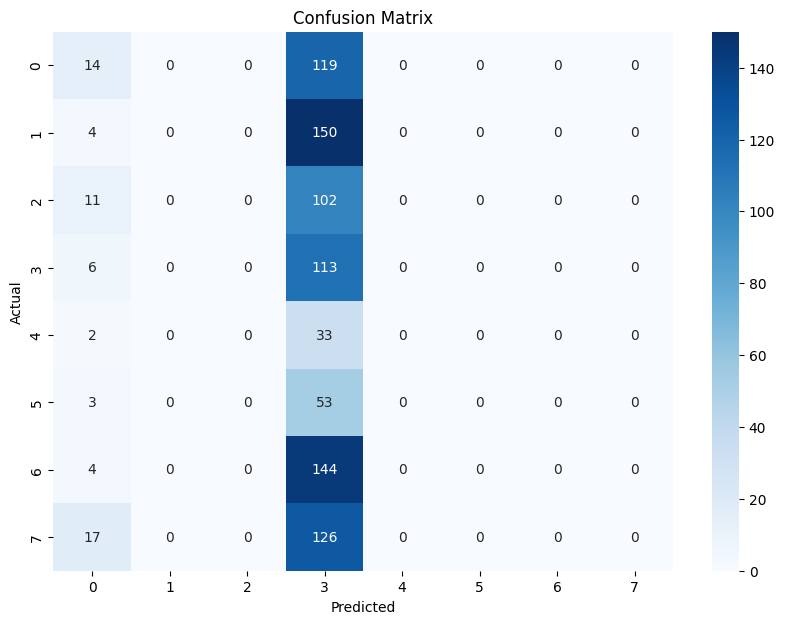

Accuracy for F8: 0.41065482796892344


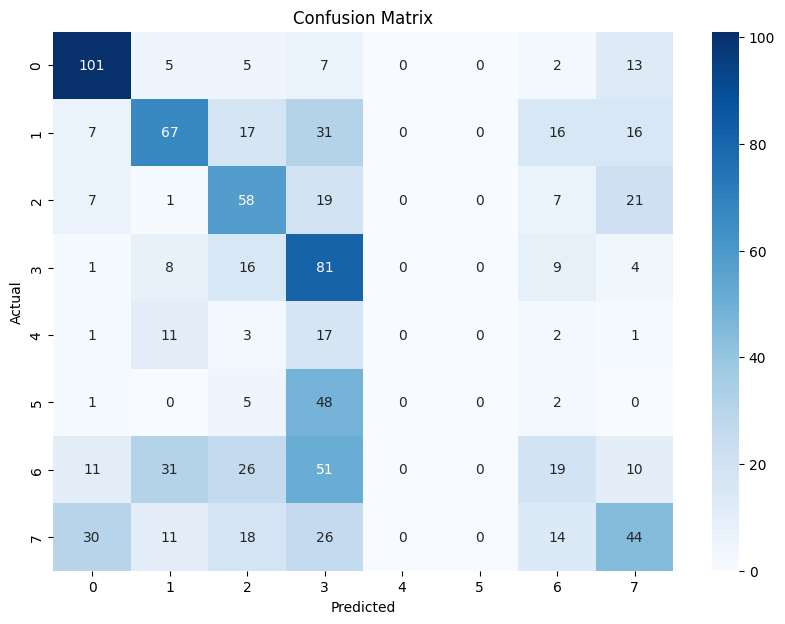

Accuracy for G1: 0.39289678135405104


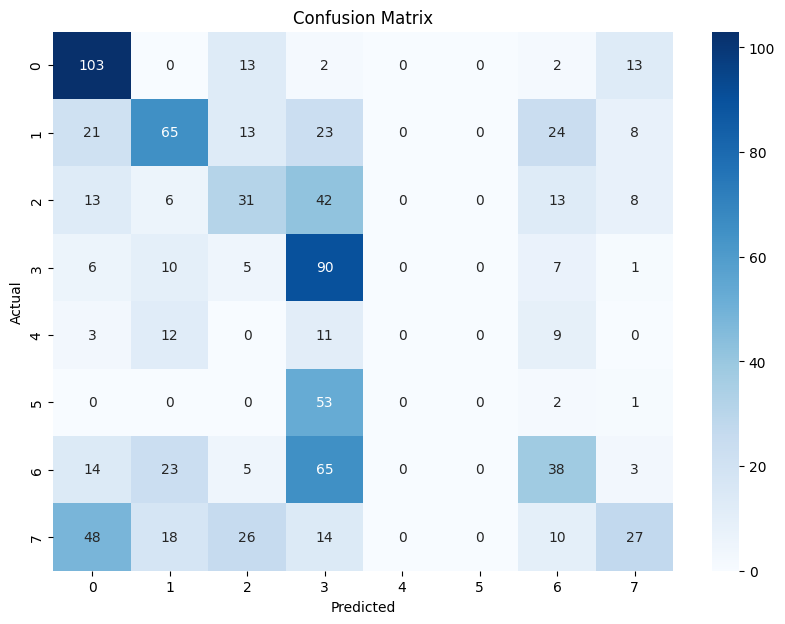


KNN results:
Accuracy for A1: 0.5005549389567148


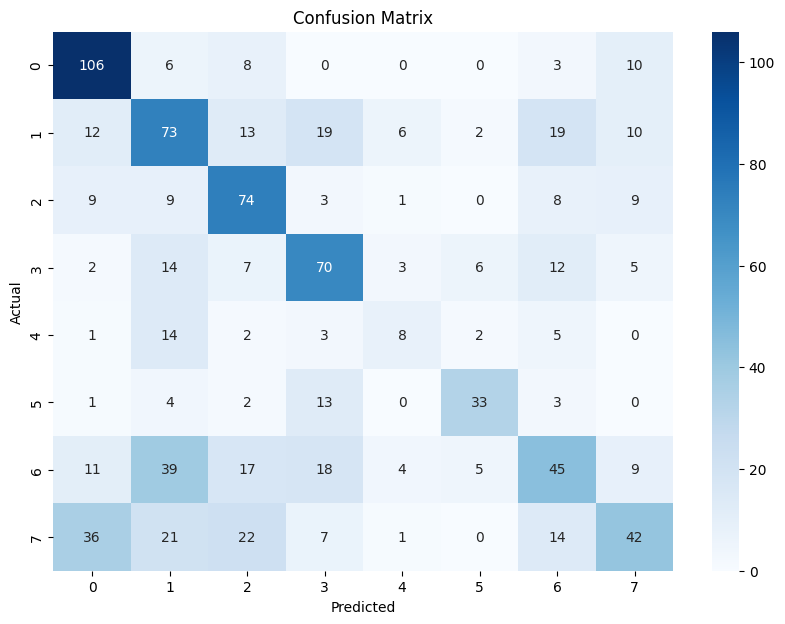

Accuracy for A2: 0.4961154273029967


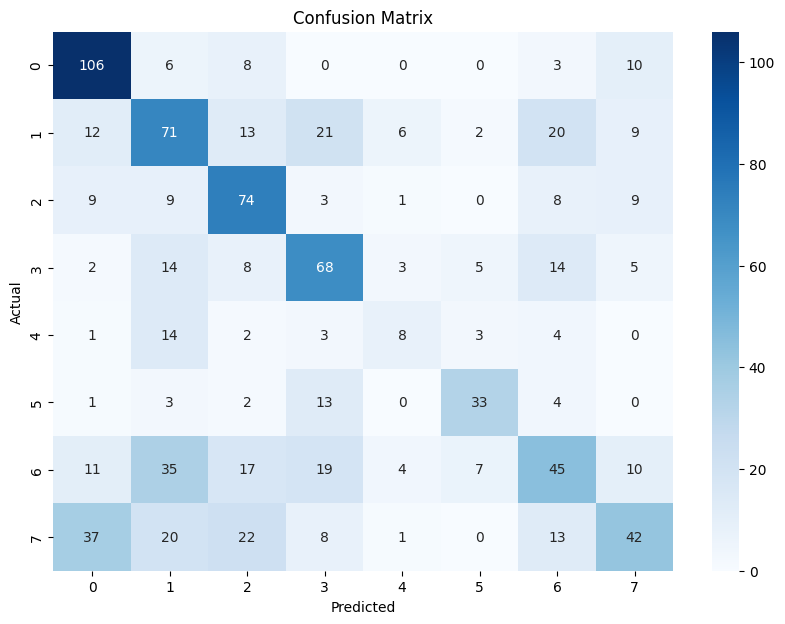

Accuracy for A3: 0.5027746947835738


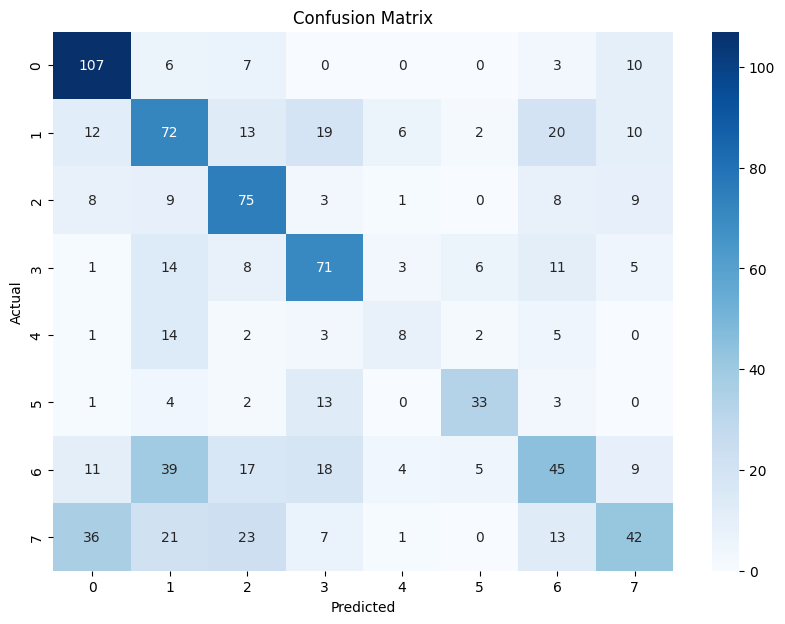

Accuracy for S1: 0.41509433962264153


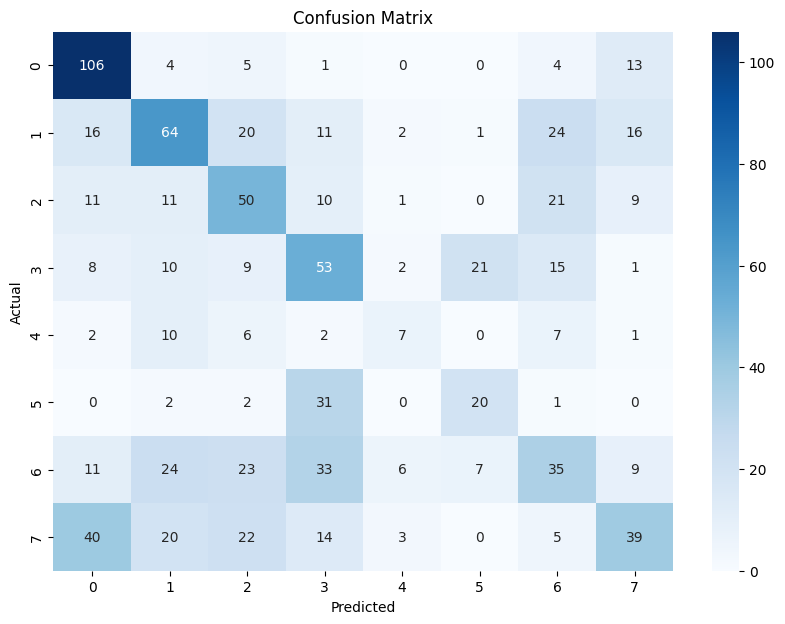

Accuracy for S2: 0.5449500554938956


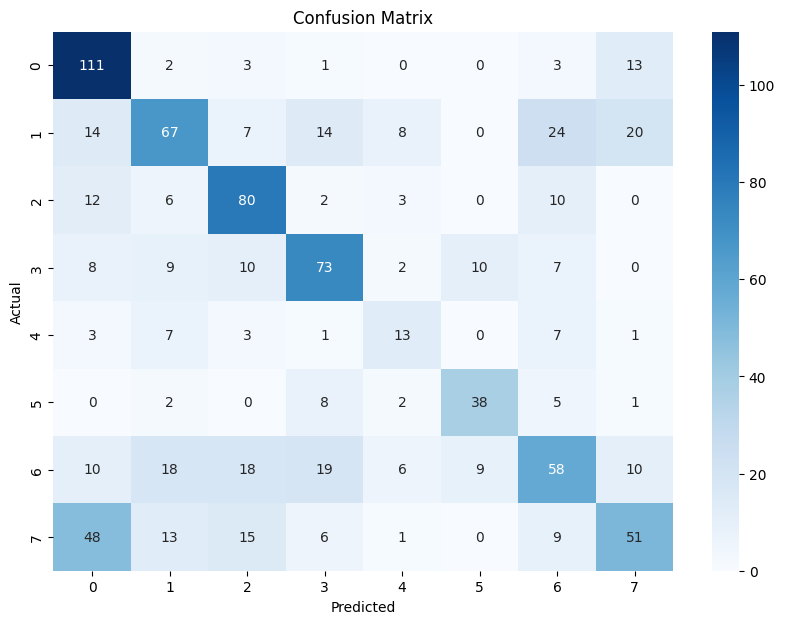

Accuracy for S3: 0.5260821309655938


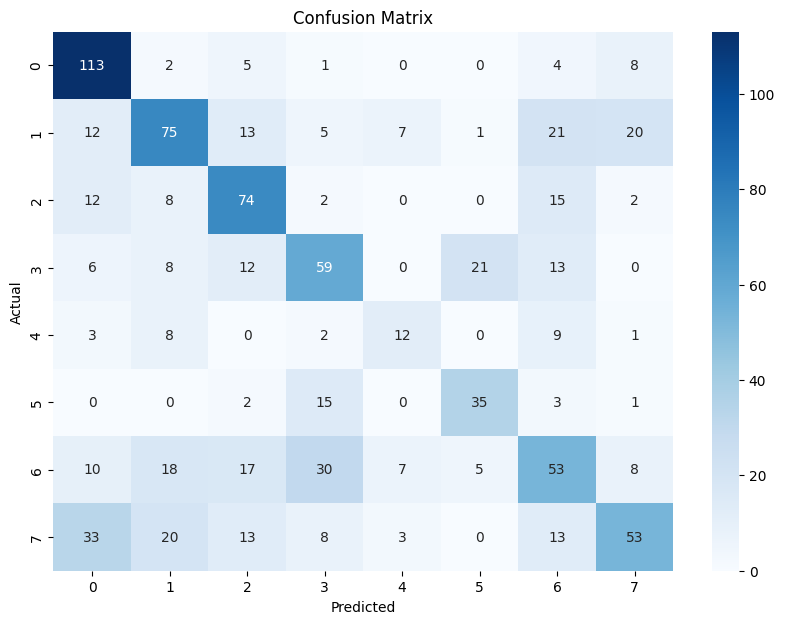

Accuracy for S4: 0.5449500554938956


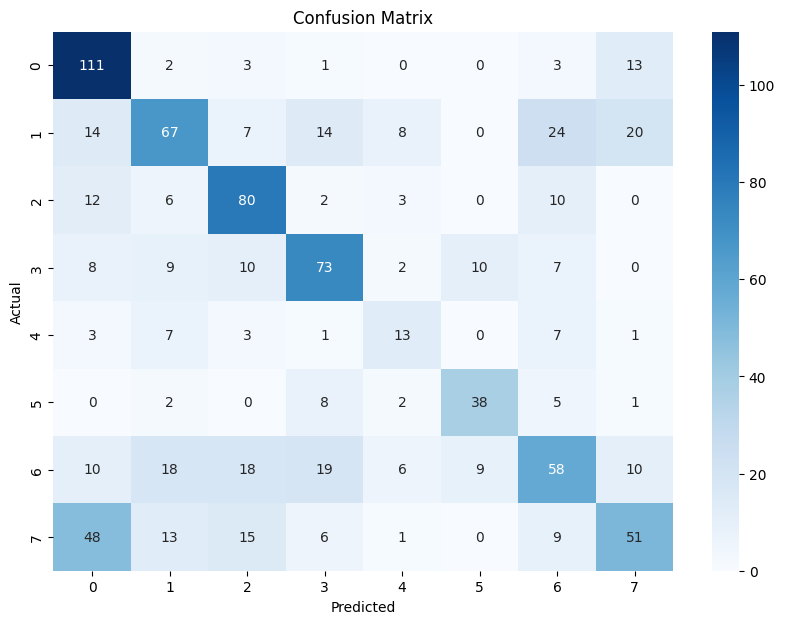

Accuracy for S6: 0.5449500554938956


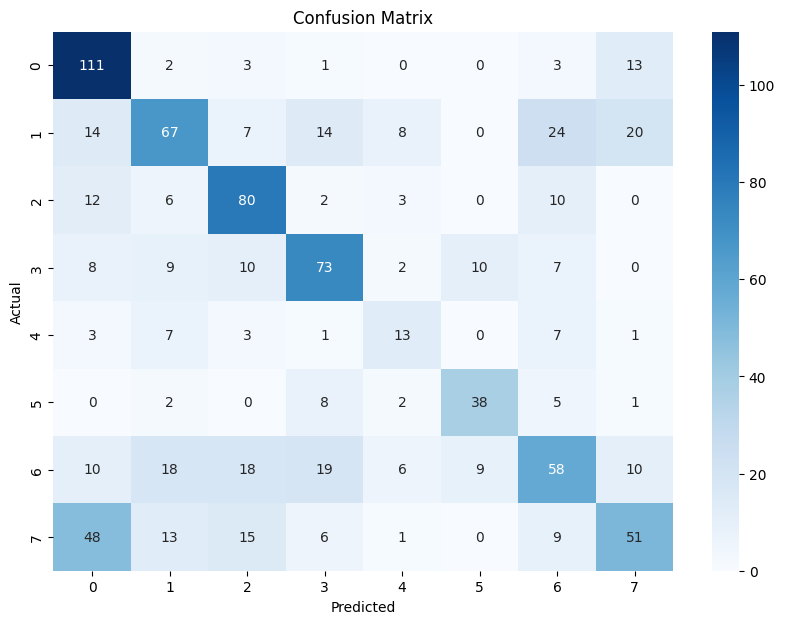

Accuracy for F1: 0.4938956714761376


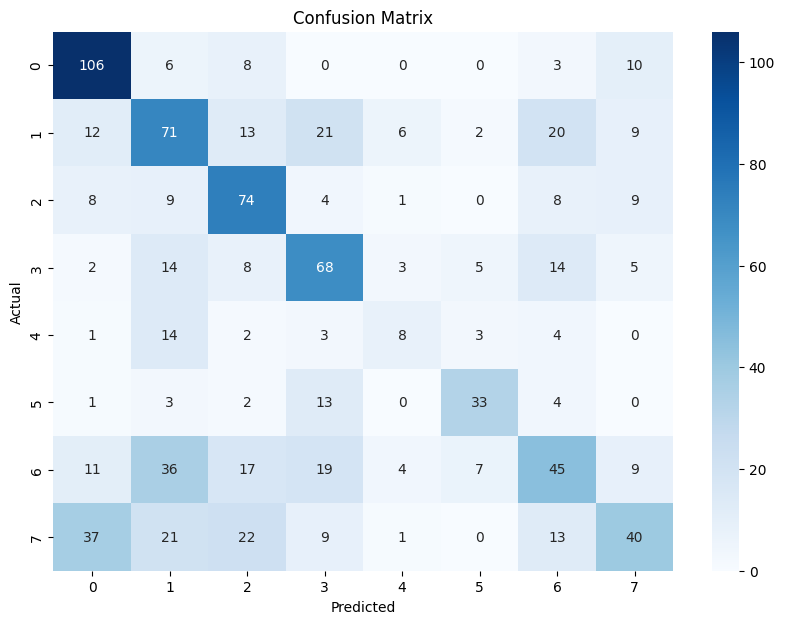

Accuracy for F2: 0.4938956714761376


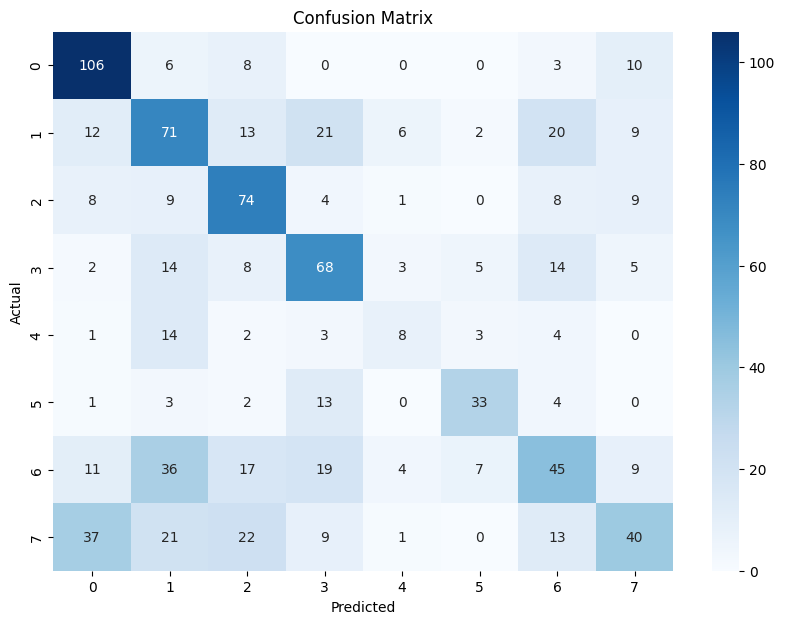

Accuracy for F4: 0.4938956714761376


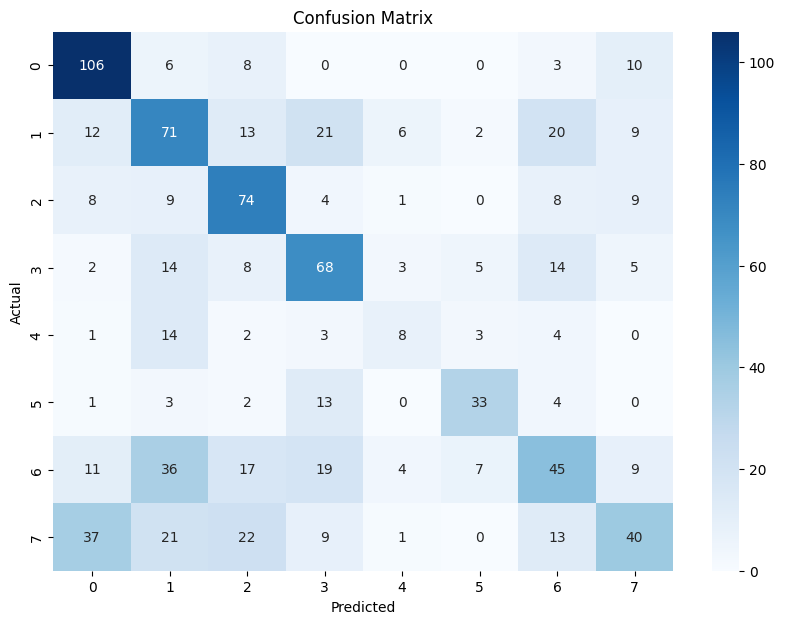

Accuracy for F5: 0.4983351831298557


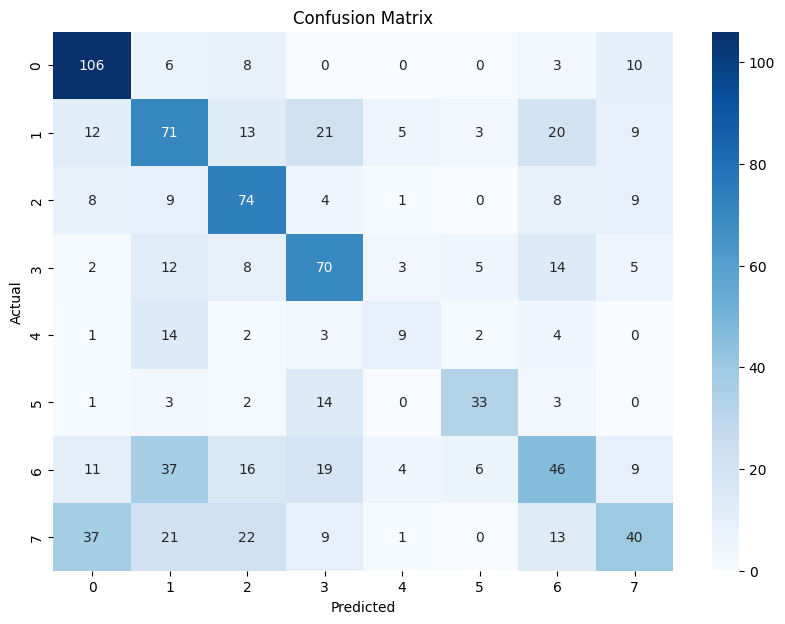

Accuracy for F6: 0.27968923418423974


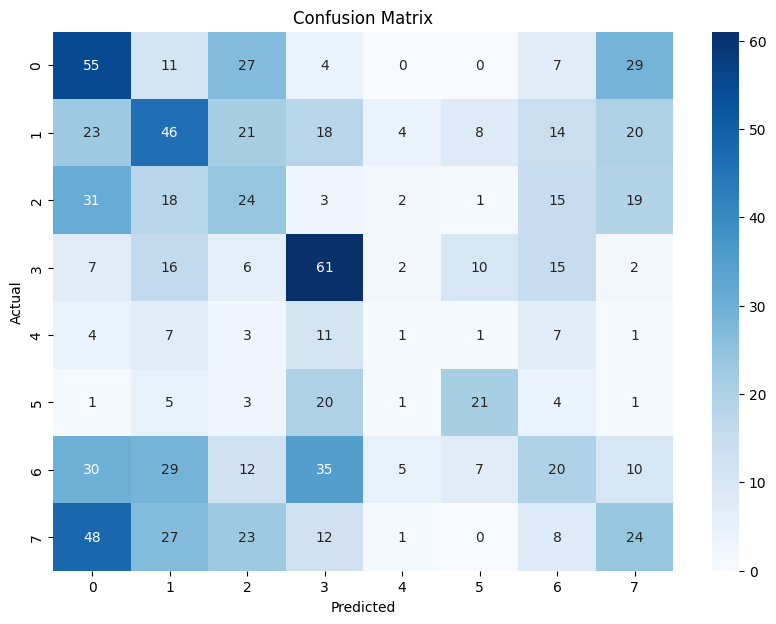

Accuracy for F8: 0.49500554938956715


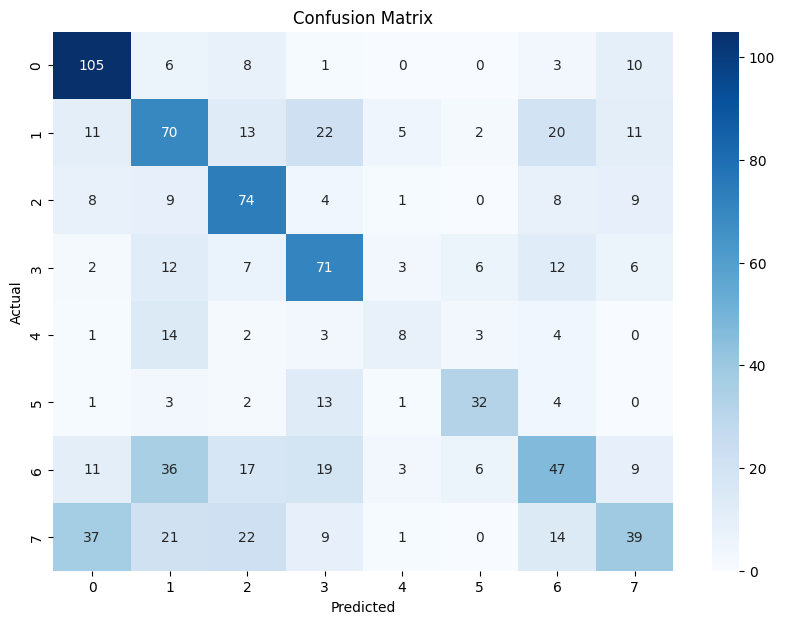

Accuracy for G1: 0.5460599334073252


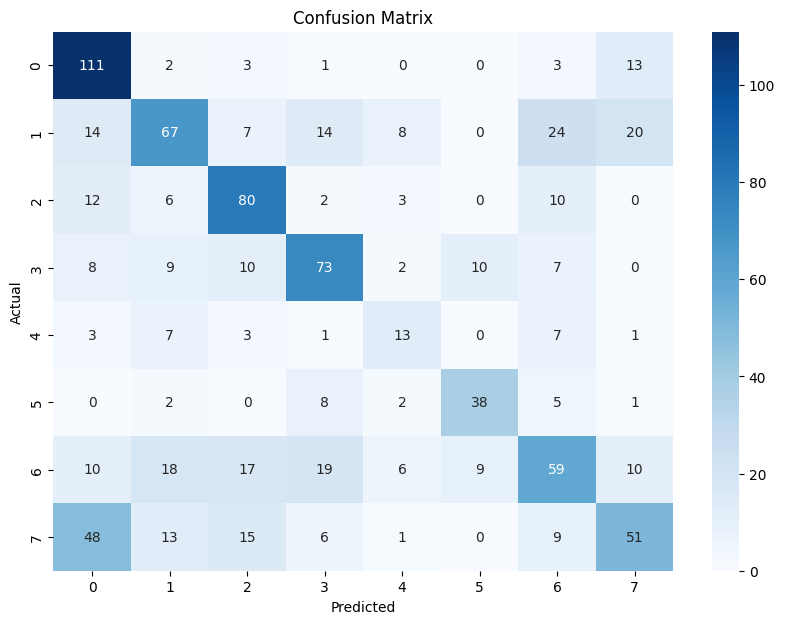

In [50]:
print('SVM results:')
train_on_single_features(full_df_cut, column_subsets, 'SVM')

print('\nKNN results:')
train_on_single_features(full_df_cut, column_subsets, 'KNN')